## Setup

imports

In [1]:
import os
import sys
import glob
import logging
from tqdm import tqdm
from datetime import datetime
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ema_pytorch import EMA
import seaborn as sns
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split

import itk
import SimpleITK as sitk
import monai
from monai.data import ImageDataset, DataLoader, decollate_batch
from monai.metrics import ROCAUCMetric
from monai.utils import set_determinism
from monai.transforms import (
    EnsureChannelFirst, Compose, 
    LoadImage, NormalizeIntensity, Orientation, ToTensor,
    Resize, RandRotate, RandFlip, RandZoom, RandGaussianNoise)

from monai.transforms import (
    EnsureChannelFirstd, Compose, 
    LoadImaged, NormalizeIntensityd, Orientationd, ToTensord,
    Resized, RandRotated, RandFlipd, RandZoomd, RandGaussianNoised)

monai.config.print_config()
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

In [2]:
path = "C:/Users/Yin/Desktop/Vrije_courses/internship/codes/data/BLT_radiomics/image_files/segs_new_raw"

In [3]:
pixelvalue = []
for file in os.listdir(path):
    if "018" in file:
        img = sitk.ReadImage(os.path.join(path, file))
        pixelvalue.append(img.GetPixelIDValue())

In [4]:
pixelvalue

[2]

In [5]:
print(img.GetPixelIDValue())

2


In [6]:
model = monai.networks.nets.DenseNet121(spatial_dims=3, in_channels=5, out_channels=3, norm='instance')
model

DenseNet121(
  (features): Sequential(
    (conv0): Conv3d(5, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
    (norm0): InstanceNorm3d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (layers): Sequential(
          (norm1): InstanceNorm3d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (relu1): ReLU(inplace=True)
          (conv1): Conv3d(64, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
          (norm2): InstanceNorm3d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (relu2): ReLU(inplace=True)
          (conv2): Conv3d(128, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
      )
      (denselayer2): _DenseLayer(
        (layers)

Set deterministic training for reproducibility

In [7]:
import multiclass_metric

In [8]:
attempt = datetime.now().strftime("%Y-%j-%M")
set_determinism(seed=0)

# Data inspect

In [17]:
## set the data and label path
script_dir = os.getcwd()
model_folder = os.path.join(script_dir, "data", "BLT_radiomics", "models", "densenet")
model_dir = os.path.join(model_folder, attempt)
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
img4D_dir = os.path.join(script_dir, "data", "BLT_radiomics", "image_files", "4D_new_registered", "images")
seg4D_dir = os.path.join(script_dir, "data", "BLT_radiomics", "image_files", "4D_new_registered", "segs")

# image files
images = []
for file in os.listdir(img4D_dir):
    if file.endswith(".nii.gz"):
        images.append(os.path.join(img4D_dir, file))
    
# segmentation files
segs = []
for file in os.listdir(seg4D_dir):
    if file.endswith(".nii.gz"):
        segs.append(os.path.join(seg4D_dir, file))

# label data
label_dir = os.path.join(script_dir, "data", "BLT_radiomics", "labels_all_phases_NEW.csv")
labels = pd.read_csv(label_dir)["Pheno"].to_numpy()
labels[labels == 4] = 2
labels = torch.from_numpy(labels)
num_class = len(np.unique(labels, axis=0))

# print(images)
# print(segs)
print(f"image data count: {len(images)}.\nsegmetation data count: {len(segs)}.\nnumber of class: {num_class}.")

image data count: 102.
segmetation data count: 102.
number of class: 3.


In [24]:

img = sitk.ReadImage(images[1])
img_size = img.GetSize()
print(img_size)

(271, 221, 86, 4)


In [30]:
slice_x

[286]

In [31]:
slice_x = list()
slice_y = list()
slice_z = list()
for image in images:
    img = sitk.ReadImage(image)
    img_size = img.GetSize() #x,y,z
    slice_x.append(img_size[0])
    slice_y.append(img_size[1])
    slice_z.append(img_size[2])

Text(0, 0.5, 'Frequency')

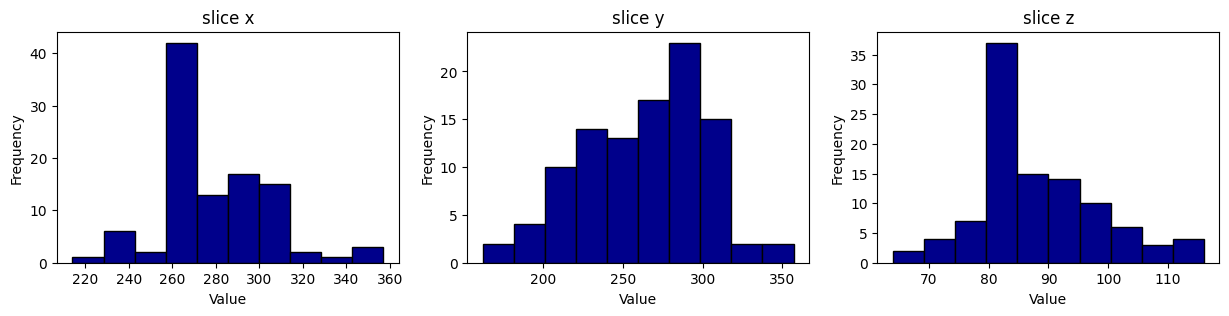

In [43]:
fig, axes = plt.subplots(1,3, figsize=(15,3))
axes[0].hist(slice_x, bins=10, color='darkblue', edgecolor='black')
axes[0].set_title("slice x")
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')

axes[1].hist(slice_y, bins=10, color='darkblue', edgecolor='black')
axes[1].set_title("slice y")
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Frequency')

axes[2].hist(slice_z, bins=10, color='darkblue', edgecolor='black')
axes[2].set_title("slice z")
axes[2].set_xlabel('Value')
axes[2].set_ylabel('Frequency')


## Data Preprocess

In [4]:
script_dir = os.getcwd()
rawimg_dir = os.path.join(script_dir, "data", "BLT_radiomics", "image_files", "images_raw")
resampling_img_dir = os.path.join(script_dir, "data", "BLT_radiomics", "image_files", "images_resampled")

rawseg_dir = os.path.join(script_dir, "data", "BLT_radiomics", "image_files", "segs_new_raw")
resampling_seg_dir = os.path.join(script_dir, "data", "BLT_radiomics", "image_files", "segs_new_resampled")

In [8]:
file_pattern = os.path.join(rawseg_dir, f"BLT_004_000*.nii.gz")
for seg_file_path in glob.glob(file_pattern):
    # Extract the part that matches '*' from the filename
    # This assumes the filename structure is consistent and splits by '_'
    # and takes the fourth part (index 3) as the matching part
    match_part = os.path.basename(seg_file_path).split('_')[2]
    print(os.path.basename(seg_file_path))
    print(match_part)

BLT_004_0001.nii.gz
0001.nii.gz


In [4]:
import os
import glob
import argparse
from tqdm import tqdm
from collections import Counter
import SimpleITK as sitk


def get_ref_info(patient_IDs:dict, ID, rawimg_dir, rawseg_dir, one:bool, is_seg=False):
    '''
    Obtain the metadata of reference image.
    
    Args:
        patient_IDs: a dictionary of patient IDs with number of phases
        ID: patient ID
        rawimg_dir: a path to raw images
        rawseg_dir: a path to raw segmentations
        is_seg: set True if the file is segmentation (mask)
        one: set True if only has one segmentation among the phases
    Returns:
        A dictionary contains image shape, spacing, direction, origin, and pixel value.
    '''
    
    # a dictionary to store metadata
    ref_info = dict()
    
    # for segmentations
    if is_seg:
        if one:
            file_pattern = os.path.join(rawseg_dir, f"BLT_{ID}_000*.nii.gz")
            for file_path in glob.glob(file_pattern):
                ref_dir = file_path
                ref_seg = sitk.ReadImage(ref_dir)
                ref_info["shape"] = ref_seg.GetSize()
                ref_info["spacing"] = ref_seg.GetSpacing()
                ref_info["direction"] = ref_seg.GetDirection()
                ref_info["origin"] = ref_seg.GetOrigin()
                ref_info["pixelvalue"] = ref_seg.GetPixelIDValue()
        else:
            oldseg_metadata = {
                "shape": [],
                "spacing": [],
                "direction": [],
                "origin": [],
                "pixelvalue": []}
            
            for i in range(patient_IDs[ID]):
                ref_dir = os.path.join(rawseg_dir, f"BLT_{ID}_000{i}.nii.gz")
                ref_seg = sitk.ReadImage(ref_dir)
                oldseg_metadata["shape"].append(ref_seg.GetSize())
                oldseg_metadata["spacing"].append(ref_seg.GetSpacing())
                oldseg_metadata["direction"].append(ref_seg.GetDirection())
                oldseg_metadata["origin"].append(ref_seg.GetOrigin())
                oldseg_metadata["pixelvalue"].append(ref_seg.GetPixelIDValue())
            # ref_info["shape"] = Counter(oldseg_metadata["shape"]).most_common(1)[0][0]
            # ref_info["spacing"] = Counter(oldseg_metadata["spacing"]).most_common(1)[0][0]
            # ref_info["direction"] = Counter(oldseg_metadata["direction"]).most_common(1)[0][0]
            # ref_info["origin"] = Counter(oldseg_metadata["origin"]).most_common(1)[0][0]
            # ref_info["pixelvalue"] = Counter(oldseg_metadata["pixelvalue"]).most_common(1)[0][0]
            ref_info["shape"] = oldseg_metadata["shape"]
            ref_info["spacing"] = oldseg_metadata["spacing"]
            ref_info["direction"] = oldseg_metadata["direction"]
            ref_info["origin"] = oldseg_metadata["origin"]
            ref_info["pixelvalue"] = oldseg_metadata["pixelvalue"]
    
    # for imgaes
    else:
        metadata = {
            "shape": [],
            "spacing": [],
            "direction": [],
            "origin": [],
            "pixelvalue": []}
        
        for i in range(patient_IDs[ID]):
            ref_dir = os.path.join(rawimg_dir, f"BLT_{ID}_000{i}.nii.gz")
            ref_img = sitk.ReadImage(ref_dir)
            metadata["shape"].append(ref_img.GetSize())
            metadata["spacing"].append(ref_img.GetSpacing())
            metadata["direction"].append(ref_img.GetDirection())
            metadata["origin"].append(ref_img.GetOrigin())
            metadata["pixelvalue"].append(ref_img.GetPixelIDValue())
        # ref_info["shape"] = Counter(metadata["shape"]).most_common(1)[0][0]
        # ref_info["spacing"] = Counter(metadata["spacing"]).most_common(1)[0][0]
        # ref_info["direction"] = Counter(metadata["direction"]).most_common(1)[0][0]
        # ref_info["origin"] = Counter(metadata["origin"]).most_common(1)[0][0]
        # ref_info["pixelvalue"] = Counter(metadata["pixelvalue"]).most_common(1)[0][0]
        ref_info["shape"] = metadata["shape"]
        ref_info["spacing"] = metadata["spacing"]
        ref_info["direction"] = metadata["direction"]
        ref_info["origin"] = metadata["origin"]
        ref_info["pixelvalue"] = metadata["pixelvalue"]
    return ref_info


In [ ]:
def resampling(image, ref_info, is_seg=False):
    '''
    Implement the image resampling.
    
    Args:
        image: the targeted image
        ref_info: a dictionary contains image shape, spacing, direction, origin, and pixel value.
        is_seg: Set True if the file is segmentation (mask)
    Returns:
        Resampled image.
    '''
    ref_spacing = (1.4062749743461609, 1.4062749743461609, 2.499995708465576)
    ref_shape = list(ref_info["shape"])
    scales = [ref_info["spacing"][i]/ref_spacing[i] for i in range(len(ref_spacing))]
    scaled_shape = [round(ref_shape[i]*scales[i]) for i in range(len(ref_shape))]
    scaled_shape = tuple(scaled_shape)
    
    resample = sitk.ResampleImageFilter()
    
    resample.SetOutputSpacing(ref_spacing)
    resample.SetSize(scaled_shape)
    resample.SetOutputDirection(ref_info["direction"])
    resample.SetOutputOrigin(ref_info["origin"])
    resample.SetDefaultPixelValue(ref_info["pixelvalue"])
   
    resample.SetTransform(sitk.Transform())

    if is_seg:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(image)

In [5]:
# resample_img = "y"
# resample_seg = "y"
# one_seg = "y"

# if not all(answer in ['y', 'n'] for answer in [one_seg, resample_img, resample_seg]):
#     raise ValueError("Input must be 'Y' or 'N'")

# one_seg_bool = True if one_seg == 'y' else False
# resample_img_bool = True if resample_img == 'y' else False
# resample_seg_bool = True if resample_seg == 'y' else False

# script_dir = os.getcwd()
# rawimg_dir = os.path.join(script_dir, "data", "BLT_radiomics", "image_files", "images_raw")
# resampling_img_dir = os.path.join(script_dir, "data", "BLT_radiomics", "image_files", "images_resampled")

# # assuming Y means it's the new files with the default path
# # assuning new files only has one segmentation file
# if one_seg_bool == True:
#     rawseg_dir = os.path.join(script_dir, "data", "BLT_radiomics", "image_files", "segs_new_raw")
#     resampling_seg_dir = os.path.join(script_dir, "data", "BLT_radiomics", "image_files", "segs_new_resampled")
# elif one_seg_bool == False:
#     rawseg_dir = os.path.join(script_dir, "data", "BLT_radiomics", "image_files", "segs_old_raw")
#     resampling_seg_dir = os.path.join(script_dir, "data", "BLT_radiomics", "image_files", "segs_old_resampled")

# # get a list of all the patient IDs and number of phases
# patient_IDs = dict()
# for file in os.listdir(rawimg_dir):
#     if file.endswith(".nii.gz"):
#         ID = file.split("_")[1]
#         if ID not in patient_IDs:
#             patient_IDs[ID] = 1
#         else:
#             patient_IDs[ID] += 1
#     else:
#         continue
# print(f"patient counts: {len(patient_IDs)}")
# print(f"file counts: {sum(patient_IDs.values())}")


patient counts: 102
file counts: 408


In [10]:
ref_info = get_ref_info(patient_IDs, "044", rawimg_dir, rawseg_dir, one_seg_bool, is_seg=False)

In [11]:
ref_info

{'shape': [(192, 192, 115), (192, 192, 90), (192, 192, 90), (192, 192, 97)],
 'spacing': [(1.953125, 1.953125, 1.9999973773956299),
  (1.953125, 1.953125, 2.500004291534424),
  (1.953125, 1.953125, 2.500004291534424),
  (1.953125, 1.953125, 2.4999966621398926)],
 'direction': [(1.0,
   0.0,
   0.0,
   0.0,
   0.9996808507480287,
   0.025262552199319825,
   0.0,
   -0.025262554259171503,
   0.9996808508000824),
  (1.0,
   0.0,
   0.0,
   0.0,
   -0.9996808507480287,
   0.025262406627393978,
   0.0,
   0.025262554259171503,
   0.9996808544787642),
  (1.0,
   0.0,
   0.0,
   0.0,
   -0.9996808507480287,
   0.025262406627393978,
   0.0,
   0.025262554259171503,
   0.9996808544787642),
  (1.0,
   0.0,
   0.0,
   0.0,
   0.9996808507480287,
   0.025262552199319825,
   0.0,
   -0.025262554259171503,
   0.9996808508000824)],
 'origin': [(-171.44798278808594, -231.45809936523438, -85.9720687866211),
  (-172.0750732421875, 141.4600372314453, -95.78142547607422),
  (-172.0750732421875, 141.460037

In [ ]:
# if resample_img_bool:
#     print("Resampling image files:")
#     for img_file in tqdm(os.listdir(rawimg_dir)):
#         # if img_file.endswith(".nii.gz"):
#         if "044" in img_file:
#             ID = img_file.split("_")[1]
#             ref_info = get_ref_info(patient_IDs, ID, rawimg_dir, rawseg_dir, one_seg_bool, is_seg=False)
#             img_dir = os.path.join(rawimg_dir, img_file)
#             img = sitk.ReadImage(img_dir)
#             resampled_img = resampling(img, ref_info, is_seg=False)
#             sitk.WriteImage(resampled_img, os.path.join(resampling_img_dir, img_file))

# if resample_seg_bool:    
#     print("Resampling segmentation files:")
#     for seg_file in tqdm(os.listdir(rawseg_dir)):
#         if seg_file.endswith(".nii.gz"):
#         # if "013" in seg_file:
#             ID = seg_file.split("_")[1]
#             ref_info = get_ref_info(patient_IDs, ID, rawimg_dir, rawseg_dir, one_seg_bool, is_seg=True)
#             seg_dir = os.path.join(rawseg_dir, seg_file)
#             seg = sitk.ReadImage(seg_dir)
#             resampled_seg = resampling(seg, ref_info, is_seg=True)
#             sitk.WriteImage(resampled_seg, os.path.join(resampling_seg_dir, seg_file))


ddddCreate 4D image and segmentation

In [14]:
def create_4Dimage_array(ID, is_seg=False):
    '''
    Update the created image arrary with the loaded image data

    Args:
        ID: Patient ID
        is_seg: Set True if the file is segmentation (mask)
    Returns:
        A 4D numpy array contains 4 images or 4 duplicated segmentations.
    '''
    n_channel = patient_IDs[ID]
    metadata = {
            "shape": [],
            "spacing": [],
            "direction": [],
            "origin": [],
            "pixelvalue": []
        }
    if is_seg:
        file_pattern = os.path.join(resampling_seg_dir, f"BLT_{ID}_000*.nii.gz")
        for file_path in glob.glob(file_pattern):
            img_dir = file_path
            img = sitk.ReadImage(img_dir)
            ref_shape = img.GetSize()
            x, y, z = ref_shape[2], ref_shape[1], ref_shape[0]
            combined_img = np.zeros([n_channel, x, y, z], np.float32)
    else:
        img_dir = os.path.join(resampling_img_dir, f"BLT_{ID}_0000.nii.gz")
        img = sitk.ReadImage(img_dir)
        ref_shape = img.GetSize()
        x, y, z = ref_shape[2], ref_shape[1], ref_shape[0]
        combined_img = np.zeros([n_channel, x, y, z], np.float32)

    metadata["shape"].append(img.GetSize())
    metadata["spacing"].append(img.GetSpacing())
    metadata["direction"].append(img.GetDirection())
    metadata["origin"].append(img.GetOrigin())
    metadata["pixelvalue"].append(img.GetPixelIDValue())
    # for i in range(n_channel):
    #     if is_seg:
    #         file_pattern = os.path.join(resampling_seg_dir, f"BLT_{ID}_000*.nii.gz")
    #         for file_path in glob.glob(file_pattern):
    #             img_dir = file_path
    #     else:
    #         img_dir = os.path.join(resampling_img_dir, f"BLT_{ID}_000{i}.nii.gz")
        
    #     print(f"Load image: {img_dir}")
    #     img = sitk.ReadImage(img_dir)
    #     metadata["shape"].append(img.GetSize())
    #     metadata["spacing"].append(img.GetSpacing())
    #     metadata["direction"].append(img.GetDirection())
    #     metadata["origin"].append(img.GetOrigin())
    #     metadata["pixelvalue"].append(img.GetPixelIDValue())
    return combined_img, metadata

In [10]:
img_4D, metadata, direction = create_4Dimage_array("186", is_seg=False)

AssertionError: Only arrays of 2 dimensions are supported.

In [94]:
metadata

{'shape': [(270, 270, 83)],
 'spacing': [(1.4062750339508057, 1.4062750339508057, 2.499995708465576)],
 'direction': [(-1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)],
 'origin': [(186.6070098876953, 174.16400146484375, 3.67645001411438)],
 'pixelvalue': [2]}

In [92]:
img_4D = itk.image_view_from_array(img_4D)

In [93]:
img_4D.GetDirection()

itkMatrixD44 ([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]])

In [ ]:
(-1.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0)

In [15]:
# for ID in ["186"]:
    
#     spacing_4D = (1.4062749743461609, 1.4062749743461609, 2.499995708465576, 1)
#     direction_4D = (-1.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0)
#     ####################
#     ### Registration ###
#     ####################
    
#     print(f"Load image data: Patient_{ID}")
    
#     ## Load image ##
#     img_4D, metadata = create_4Dimage_array(ID, is_seg=False)
#     image_itk_4D = itk.image_view_from_array(img_4D)
    
#     # Setting groupwise parameter object
#     print("Setting")
#     parameter_object = itk.ParameterObject.New()
#     parameter_object.AddParameterFile("./Par0047Groupwise.txt")
    
#     print("Start registration")  
#     result_image, result_transform_parameters = itk.elastix_registration_method(
#         image_itk_4D,  image_itk_4D,
#         parameter_object=parameter_object,
#         log_to_console=True)
#     result_image.SetSpacing(spacing_4D)
#     result_image.SetDefaultPixelValue(metadata["pixelvalue"])
#     print("ok")
#     break
#     # result_image.SetDefaultPixelValue(metadata["pixelvalue"])
    
#     ## Load segmentation ##
#     # mask_4D = create_4Dimage_array(ID, is_seg=True)
#     # mask_itk_4D = itk.image_view_from_array(mask_4D)
    
#     # print("Start transformix")
#     # result_transform_parameters.SetParameter("FinalBSplineInterpolationOrder", "0")
#     # result_mask_transformix = itk.transformix_filter(
#     #     mask_itk_4D,
#     #     result_transform_parameters)
    
#     # ref_phase = seg_file_num[ID]
#     # result_mask_transformix = itk.image_view_from_array(result_mask_transformix)
#     # for i in range(result_mask_transformix.shape[0]):
#     #     result_mask_transformix[i,:,:,:] = result_mask_transformix[ref_phase,:,:,:]
#     # result_mask_transformix = itk.image_view_from_array(result_mask_transformix)
#     # result_mask_transformix.SetSpacing(spacing_4D)
    
    
#     # print("Save results")
#     # # Set the path for saving 4D images
#     # img4D_out_dir = os.path.join(data_dir, "4D_new_registered", "images", f"BLT_{ID}.nii.gz")
#     # seg4D_out_dir = os.path.join(data_dir, "4D_new_registered", "segs", f"BLT_{ID}.nii.gz")
#     # itk.imwrite(result_image, img4D_out_dir)
#     # itk.imwrite(result_mask_transformix, seg4D_out_dir)
    
#     # param_out_dir = os.path.join(data_dir, "4D_new_registered", "parameters", f"BLT_{ID}.txt")
#     # parameter_object.WriteParameterFile(result_transform_parameters, param_out_dir)

Load image data: Patient_186
Setting


# DenseNet

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Functions

In [11]:
def check_dataoverlap(train_x, val_x, test_x):
    '''
    Args:
        train_x: a list of training data
        val_x: a list of validation data
        test_x: a list of testing data
    Return:
        print if the data has overlapping elements.
    '''
    train_patients = list()
    val_patients = list()
    test_patients = list()
    
    for i in train_x:
        train_patients.append(int(i.split('.')[0].split("_")[-1]))
    for i in val_x:
        val_patients.append(int(i.split('.')[0].split("_")[-1]))
    for i in test_x:
        test_patients.append(int(i.split('.')[0].split("_")[-1]))
    
    overlapped = False
    numbers = list()
    for number in train_patients:
        if number in val_patients or number in test_patients:
            numbers.append(number)
            overlapped = True
    if overlapped:
        print(f"Overlapped number found: {numbers}")
    else:
        print("No overlapped numbers found.")

In [12]:
def balanced_sampler(labels):
    '''
    Make a samples that is balanced between the classes. can be passed as an argument to the dataloader.

    args:
        labels: torch tensor of labels, of the training samples.
    returns:
        sampler: a balanced sampler.
    '''
    labels_unique, counts = np.unique(labels, return_counts=True)
    class_weights = [sum(counts) / c for c in counts]
    example_weights = [class_weights[e] for e in labels]
    sampler = WeightedRandomSampler(weights=example_weights, num_samples=len(labels), replacement=True)
    
    return sampler

In [13]:
def create_empty_predict_lists(device):
    y = torch.tensor([], dtype=torch.long, device=device)
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y_pred_argmax = torch.tensor([], dtype=torch.long, device=device)
    return y, y_pred, y_pred_argmax

In [14]:
def calaulate_auc(y, y_pred, y_trans, y_pred_trans):
    '''
    Args:
        y: a tensor containing true labels
        y_pred: a tensor containing prdicted values without argmax
        y_trans: transformation setting for y
        y_pred_trans: transformation setting for y_pred
    Return:
        a float of auc value
    '''
    auc_metric = ROCAUCMetric()
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    auc_value = auc_metric.aggregate()
    auc_metric.reset()
    del y_pred_act, y_onehot
    return auc_value

In [15]:
def calaulate_metric(y, y_pred):
    '''
    Args:
        y: a tensor contating true labels
        y_pred: a tensor containing prdicted values after argmax
    Return:
        metric: a tuple containing 4 values of TP, FP, FN, TN
        avg_sensitivity: average sensitivity value
        avg_specificity: average specificity value
    '''
    # Move tensors to CPU if they are on GPU
    if y.is_cuda:
        y = y.cpu()
    if y_pred.is_cuda:
        y_pred = y_pred.cpu()
        
    cm = confusion_matrix(y, y_pred)
    TP = np.diag(cm)
    FP = np.sum(cm, axis=0) - TP
    FN = np.sum(cm, axis=1) - TP
    TN = np.sum(cm) - (FP + FN + TP)
    # Calculate Sensitivity(Recall) and Specificity for each class
    sensitivity = TP / (TP + FN)
    avg_sensitivity = sum(sensitivity)/len(sensitivity)
    specificity = TN / (TN + FP)
    avg_specificity = sum(specificity)/len(specificity)
    return (TP, FP, FN, TN), avg_sensitivity, avg_specificity

In [16]:
def empty_history_dict():
    history_dict = {
    "epoch_loss": [],
    "Accuracy": [],
    "Sensitivity": [],
    "Specificity": [],
    "Precision": [],
    "NPV": [],
    "F1_score": [],
    "AUC": [],
    "AverageAccuracy": [],
    "metric": []
    }
    return history_dict

In [17]:
def append_metrics(dictionary, Accuracy, Sensitivity, Specificity, Precision, NPV, F1_score, AUC, AverageAccuracy, metric):
    dictionary["Accuracy"].append(Accuracy)
    dictionary["Sensitivity"].append(Sensitivity)
    dictionary["Specificity"].append(Specificity)
    dictionary["Precision"].append(Precision)
    dictionary["NPV"].append(NPV)
    dictionary["F1_score"].append(F1_score)
    dictionary["AUC"].append(AUC)
    dictionary["AverageAccuracy"].append(AverageAccuracy)
    dictionary["metric"].append(metric)
    return dictionary

In [18]:
# def pairwise_auc(y_truth, y_score, class_i, class_j):
#     # Filter out the probabilities for class_i and class_j
#     y_score = [est[class_i] for ref, est in zip(y_truth, y_score) if ref in (class_i, class_j)]
#     y_truth = [ref for ref in y_truth if ref in (class_i, class_j)]

#     # Sort the y_truth by the estimated probabilities
#     sorted_y_truth = [y for x, y in sorted(zip(y_score, y_truth), key=lambda p: p[0])]

#     # Calculated the sum of ranks for class_i
#     sum_rank = 0
#     for index, element in enumerate(sorted_y_truth):
#         if element == class_i:
#             sum_rank += index + 1
#     sum_rank = float(sum_rank)

#     # Get the counts for class_i and class_j
#     n_class_i = float(y_truth.count(class_i))
#     n_class_j = float(y_truth.count(class_j))

#     # If a class in empty, AUC is 0.0
#     if n_class_i == 0 or n_class_j == 0:
#         return 0.0

#     # Calculate the pairwise AUC
#     return (sum_rank - (0.5 * n_class_i * (n_class_i + 1))) / (n_class_i * n_class_j)

In [19]:
# def multi_class_auc(y_truth, y_score):
#     classes = np.unique(y_truth)

#     # if any(t == 0.0 for t in np.sum(y_score, axis=1)):
#     #     raise ValueError('No AUC is calculated, output probabilities are missing')

#     pairwise_auc_list = [0.5 * (pairwise_auc(y_truth, y_score, i, j) +
#                                 pairwise_auc(y_truth, y_score, j, i)) for i in classes for j in classes if i < j]

#     c = len(classes)
#     return (2.0 * sum(pairwise_auc_list)) / (c * (c - 1))

In [20]:

# def performance_multiclass(y_truth, y_prediction, y_score=None, beta=1):
#     '''
#     Multiclass performance metrics.

#     y_truth and y_prediction should both be lists with the multiclass label of each
#     object, e.g.

#     y_truth = [0, 0,	0,	0,	0,	0,	2,	2,	1,	1,	2]    ### Groundtruth
#     y_prediction = [0, 0,	0,	0,	0,	0,	1,	2,	1,	2,	2]    ### Predicted labels
#     y_score = [[0.3, 0.3, 0.4], [0.2, 0.6, 0.2], ... ] # Normalized score per patient for all labels (three in this example)


#     Calculation of accuracy accorading to formula suggested in CAD Dementia Grand Challege http://caddementia.grand-challenge.org
#     and the TADPOLE challenge https://tadpole.grand-challenge.org/Performance_Metrics/
#     Calculation of Multi Class AUC according to classpy: https://bitbucket.org/bigr_erasmusmc/classpy/src/master/classpy/multi_class_auc.py

#     '''
#     if y_truth.is_cuda:
#         y_truth = y_truth.cpu()
#     if y_prediction.is_cuda:
#         y_prediction = y_prediction.cpu()
    
#     cm = confusion_matrix(y_truth, y_prediction)

#     # Determine no. of classes
#     labels_class = np.unique(y_truth)
#     n_class = len(labels_class)

#     # Splits confusion matrix in true and false positives and negatives
#     TP = np.zeros(shape=(1, n_class), dtype=int)
#     FN = np.zeros(shape=(1, n_class), dtype=int)
#     FP = np.zeros(shape=(1, n_class), dtype=int)
#     TN = np.zeros(shape=(1, n_class), dtype=int)
#     n = np.zeros(shape=(1, n_class), dtype=int)
#     for i in range(n_class):
#         TP[:, i] = cm[i, i]
#         FN[:, i] = np.sum(cm[i, :])-cm[i, i]
#         FP[:, i] = np.sum(cm[:, i])-cm[i, i]
#         TN[:, i] = np.sum(cm[:])-TP[:, i]-FP[:, i]-FN[:, i]

#     n = np.sum(cm)

#     # Determine Accuracy
#     Accuracy = (np.sum(TP))/n

#     # BCA: Balanced Class Accuracy
#     BCA = list()
#     for i in range(n_class):
#         BCAi = 1/2*(TP[:, i]/(TP[:, i] + FN[:, i]) + TN[:, i]/(TN[:, i] + FP[:, i]))
#         BCA.append(BCAi)

#     AverageAccuracy = np.mean(BCA)

#     # Determine total positives and negatives
#     P = TP + FN
#     N = FP + TN

#     # Calculation of sensitivity
#     Sensitivity = TP/P
#     Sensitivity = np.mean(Sensitivity)

#     # Calculation of specifitity
#     Specificity = TN/N
#     Specificity = np.mean(Specificity)

#     # Calculation of precision
#     Precision = TP/(TP+FP)
#     Precision = np.nan_to_num(Precision)
#     Precision = np.mean(Precision)

#     # Calculation of NPV
#     NPV = TN/(TN+FN)
#     NPV = np.nan_to_num(NPV)
#     NPV = np.mean(NPV)

#     # Calculation of F1_Score
#     F1_score = ((1+(beta**2))*(Sensitivity*Precision))/((beta**2)*(Precision + Sensitivity))
#     F1_score = np.nan_to_num(F1_score)
#     F1_score = np.mean(F1_score)

#     # Calculation of Multi Class AUC according to classpy: https://bitbucket.org/bigr_erasmusmc/classpy/src/master/classpy/multi_class_auc.py
#     if y_score is not None:
#         if y_score.is_cuda:
#             y_score = y_score.cpu()
#         softmax = torch.nn.Softmax(dim=1)
#         y_score_soft = softmax(y_score)
#         AUC = multi_class_auc(y_truth, y_score_soft)
#     else:
#         AUC = None

#     return Accuracy, Sensitivity, Specificity, Precision, NPV, F1_score, AUC, AverageAccuracy, cm

In [21]:
def write_csv(dictionary, fold, split, model_dir):
    '''
    Args:
        dictionary: a dictionary containing the loss and metric values
        fold: the k-fold number now it is
        split: tr, ts, or val
    '''
    # Convert dictionary to rows of data
    rows = []
    epochs = range(1, len(next(iter(dictionary.values()))) + 1)
    for epoch in epochs:
        row = [epoch]
        for key in dictionary:
            row.append(dictionary[key][epoch - 1])
        rows.append(row)

    # Write to CSV
    csv_path = os.path.join(model_dir, "csv")
    if not os.path.exists(csv_path):
        os.makedirs(csv_path)
    filename = f"{split}_fold{fold}.csv"
    file_dir = os.path.join(csv_path, filename)
    with open(file_dir, 'w', newline='') as file:
        writer = csv.writer(file)
        # Writing headers
        headers = ['Epoch'] + [key for key in dictionary.keys() if key != "metric"]
        writer.writerow(headers)
        # Writing data
        writer.writerows(rows)

    print(f"{filename} created")

## Prepare training

Set path

In [22]:
## set the data and label path
script_dir = os.getcwd()
model_folder = os.path.join(script_dir, "data", "BLT_radiomics", "models", "densenet")
model_dir = os.path.join(model_folder, attempt)
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
img4D_dir = os.path.join(script_dir, "data", "BLT_radiomics", "image_files", "4D_new_registered", "images")
seg4D_dir = os.path.join(script_dir, "data", "BLT_radiomics", "image_files", "4D_new_registered", "segs")

# image files
images = []
for file in os.listdir(img4D_dir):
    if file.endswith(".nii.gz"):
        images.append(os.path.join(img4D_dir, file))
    
# segmentation files
segs = []
for file in os.listdir(seg4D_dir):
    if file.endswith(".nii.gz"):
        segs.append(os.path.join(seg4D_dir, file))

# label data
label_dir = os.path.join(script_dir, "data", "BLT_radiomics", "labels_all_phases_NEW.csv")
labels = pd.read_csv(label_dir)["Pheno"].to_numpy()
labels[labels == 4] = 2
labels = torch.from_numpy(labels)
num_class = len(np.unique(labels, axis=0))

print(f"image data count: {len(images)}.\nsegmetation data count: {len(segs)}.\nnumber of class: {num_class}.")

image data count: 102.
segmetation data count: 102.
number of class: 3.


In [23]:
train_img_transforms = Compose([
    EnsureChannelFirst(),
    Orientation(axcodes="RAS"),
    NormalizeIntensity(),
    # Data augmentation
    RandZoom(prob = 0.3, min_zoom=1.0, max_zoom=1.2),
    RandRotate(range_z=0.35, prob=0.3),
    RandFlip(prob = 0.5),
    RandGaussianNoise(prob=0.5, std=0.05),
    ToTensor()])

train_seg_transforms = Compose([
    EnsureChannelFirst(),
    Orientation(axcodes="RAS"),
    # Data augmentation
    RandZoom(prob=0.3, min_zoom=1.0, max_zoom=1.2),
    RandRotate(range_z=0.35, prob=0.3),
    RandFlip(prob = 0.5),
    ToTensor()])

val_img_transforms = Compose([
    EnsureChannelFirst(),
    NormalizeIntensity(),
    ToTensor()])
val_seg_transforms = Compose([
    EnsureChannelFirst(),
    ToTensor()])

In [75]:
kfold = 2
ALL_y_ts, ALL_y_ts_bm_pred, ALL_y_ts_bm_pred_argmax = create_empty_predict_lists(device)
_, ALL_y_ts_fm_pred, ALL_y_ts_fm_pred_argmax = create_empty_predict_lists(device)
    
skf = StratifiedKFold(n_splits=kfold)
for fold, (train_val_idx, test_idx) in enumerate(skf.split(images, labels)):
    print("-"*30)
    print(f"Fold: {fold+1}/{kfold}")
    train_val_x, test_x = [images[i] for i in train_val_idx], [images[i] for i in test_idx]
    train_val_seg, test_seg = [segs[i] for i in train_val_idx], [segs[i] for i in test_idx]
    train_val_y, test_y = [labels[i] for i in train_val_idx], [labels[i] for i in test_idx]
    
    train_x, val_x, train_y, val_y = train_test_split(train_val_x, train_val_y, test_size=0.25, random_state=1, stratify=train_val_y)
    indices = np.arange(len(train_val_x))
    train_idx, val_idx = train_test_split(indices, test_size=0.25, random_state=1, stratify=train_val_y)
    train_x = [train_val_x[i] for i in train_idx]
    train_seg = [train_val_seg[i] for i in train_idx]
    train_y = [train_val_y[i] for i in train_idx]
    val_x = [train_val_x[i] for i in val_idx]
    val_seg = [train_val_seg[i] for i in val_idx]
    val_y = [train_val_y[i] for i in val_idx]
    check_dataoverlap(train_x, val_x, test_x)

    train_ds = ImageDataset(image_files=train_x, seg_files=train_seg, labels=train_y,
                            transform=train_img_transforms, seg_transform=train_seg_transforms)
    train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())
    val_ds = ImageDataset(image_files=val_x, seg_files=val_seg, labels=val_y, 
                        transform=val_img_transforms, seg_transform=val_seg_transforms)
    val_loader = DataLoader(val_ds, batch_size=1, num_workers=2, pin_memory=torch.cuda.is_available())
    

------------------------------
Fold: 1/2
No overlapped numbers found.
------------------------------
Fold: 2/2
No overlapped numbers found.


In [81]:
for batch_data in train_loader:
    train_images, train_segs, train_labels = (
        batch_data[0].to(device), 
        batch_data[1].to(device), 
        batch_data[2].to(device))
    masked_train_images = torch.cat((train_images,train_segs[:,0:1,:,:]), dim=1)
    break

In [52]:
train_segs.shape

torch.Size([1, 4, 271, 221, 86])

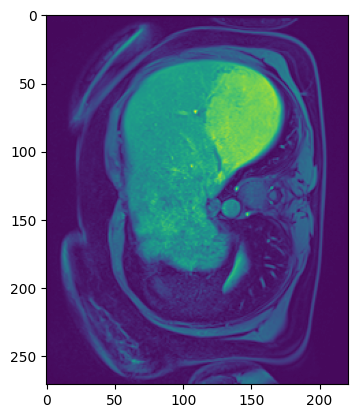

In [83]:
plt.imshow(train_images[0,1,:,:,35])

In [85]:
train_segs

metatensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          ...,

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
       

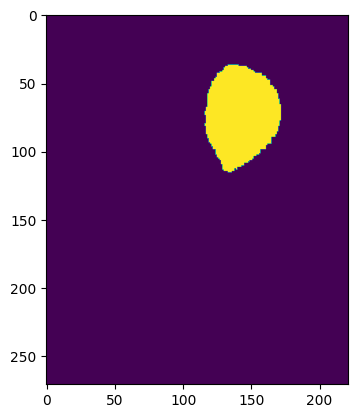

In [84]:
plt.imshow(train_segs[0,1,:,:,35])

In [47]:
train_images.shape

torch.Size([1, 4, 271, 221, 86])

In [30]:
####################
##      Setup     ##
####################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
attempt = datetime.now().strftime("%Y-%m-%d-%M")
set_determinism(seed=0)

kfold = 2
random_state = 1
learning_rate = 1e-4
max_epochs = 2

print("-"*30)
print("\n## Settings -- BLT_radiomics (Binary)")
print(f"Files will be save at: densenet_binary/{attempt}")
print(f"kfold: {kfold}; random_state: {random_state}")
print(f"learning rate: {learning_rate}; max_epochs: {max_epochs}")

####################
### Set path, change if needed
script_dir = os.getcwd()
model_folder = os.path.join(script_dir, "..", "data", "BLT_radiomics", "models", "densenet_binary")
model_dir = os.path.join(model_folder, attempt)
if not os.path.exists(model_dir):
    os.makedirs(model_dir, exist_ok=True)

if 'r098906' in script_dir:
    GPU_cluster = True
else:
    GPU_cluster = False

if GPU_cluster:
    img4D_dir = "/data/scratch/r098906/BLT_radiomics/4D_new_registered/images"
    seg4D_dir = "/data/scratch/r098906/BLT_radiomics/4D_new_registered/segs"
    label_dir = os.path.join(script_dir, "..", "data", "labels_all_phases_NEW.csv")
else:
    img4D_dir = os.path.join(script_dir, "data", "BLT_radiomics", "image_files", "4D_new_registered", "images")
    seg4D_dir = os.path.join(script_dir, "data", "BLT_radiomics", "image_files", "4D_new_registered", "segs")
    label_dir = os.path.join(script_dir, "data", "BLT_radiomics", "labels_all_phases_NEW.csv")


####################
### Load data
# images and segmentations
images = []     # image files
for file in os.listdir(img4D_dir):
    if file.endswith(".nii.gz"):
        images.append(os.path.join(img4D_dir, file))
segs = []       # segmentation files
for file in os.listdir(seg4D_dir):
    if file.endswith(".nii.gz"):
        segs.append(os.path.join(seg4D_dir, file))

# label
labels = pd.read_csv(label_dir)["Malignant"].to_numpy()
labels = torch.from_numpy(labels)
num_class = len(np.unique(labels, axis=0))
print(f"\nImage data count: {len(images)}.\nSegmetation data count: {len(segs)}.\nNumber of class: {num_class}.\n\n")

####################
##   Transforms   ##
####################
train_img_transforms = Compose([
    EnsureChannelFirst(),
    Orientation(axcodes="RAS"),
    NormalizeIntensity(),
    # Data augmentation
    RandZoom(prob = 0.3, min_zoom=1.0, max_zoom=1.2),
    RandRotate(range_z=0.35, prob=0.3),
    RandFlip(prob = 0.5),
    RandGaussianNoise(prob=0.5, std=0.05),
    ToTensor()])

train_seg_transforms = Compose([
    EnsureChannelFirst(),
    Orientation(axcodes="RAS"),
    # Data augmentation
    RandZoom(prob=0.3, min_zoom=1.0, max_zoom=1.2),
    RandRotate(range_z=0.35, prob=0.3),
    RandFlip(prob = 0.5),
    ToTensor()])

val_img_transforms = Compose([
    EnsureChannelFirst(),
    NormalizeIntensity(),
    ToTensor()])
val_seg_transforms = Compose([
    EnsureChannelFirst(),
    ToTensor()])


######################
## Cross validation ##
######################
# lists to store data from the cv 
metrics_best = list()
metrics_final = list()
models_best = list()
models_final = list()
models_finalEMA = list()
models_bestEMA = list()
train_history_cv = list()
val_history_cv = list() 

ALL_y_ts, ALL_y_ts_bm_pred, ALL_y_ts_bm_pred_argmax = create_empty_predict_lists(device)
_, ALL_y_ts_fm_pred, ALL_y_ts_fm_pred_argmax = create_empty_predict_lists(device)

skf = StratifiedKFold(n_splits=kfold)
for fold, (train_val_idx, test_idx) in enumerate(skf.split(images, labels)):
    print("-"*30)
    print(f"Fold: {fold+1}/{kfold}")
    train_val_x, test_x = [images[i] for i in train_val_idx], [images[i] for i in test_idx]
    train_val_seg, test_seg = [segs[i] for i in train_val_idx], [segs[i] for i in test_idx]
    train_val_y, test_y = [labels[i] for i in train_val_idx], [labels[i] for i in test_idx]
    
    indices = np.arange(len(train_val_x))
    train_idx, val_idx = train_test_split(indices, test_size=0.25, random_state=random_state, stratify=train_val_y)
    train_x = [train_val_x[i] for i in train_idx]
    train_seg = [train_val_seg[i] for i in train_idx]
    train_y = [train_val_y[i] for i in train_idx]
    val_x = [train_val_x[i] for i in val_idx]
    val_seg = [train_val_seg[i] for i in val_idx]
    val_y = [train_val_y[i] for i in val_idx]
    print("train_x", train_x)
    print("train_seg", train_seg)
    print("train_y", train_y)
    print("val_x", val_x)
    print("val_seg", val_seg)
    print("val_y", val_y)
    print("ts_x", test_x)
    print("ts_seg", test_seg)
    print("ts_y", test_y)

------------------------------

## Settings -- BLT_radiomics (Binary)
Files will be save at: densenet_binary/2024-03-09-04
kfold: 2; random_state: 1
learning rate: 0.0001; max_epochs: 2

Image data count: 102.
Segmetation data count: 102.
Number of class: 2.


------------------------------
Fold: 1/2
train_x ['c:\\Users\\Yin\\Desktop\\Vrije_courses\\internship\\codes\\data\\BLT_radiomics\\image_files\\4D_new_registered\\images\\BLT_109.nii.gz', 'c:\\Users\\Yin\\Desktop\\Vrije_courses\\internship\\codes\\data\\BLT_radiomics\\image_files\\4D_new_registered\\images\\BLT_120.nii.gz', 'c:\\Users\\Yin\\Desktop\\Vrije_courses\\internship\\codes\\data\\BLT_radiomics\\image_files\\4D_new_registered\\images\\BLT_108.nii.gz', 'c:\\Users\\Yin\\Desktop\\Vrije_courses\\internship\\codes\\data\\BLT_radiomics\\image_files\\4D_new_registered\\images\\BLT_299.nii.gz', 'c:\\Users\\Yin\\Desktop\\Vrije_courses\\internship\\codes\\data\\BLT_radiomics\\image_files\\4D_new_registered\\images\\BLT_092.nii.gz',

In [24]:
model_aaa = monai.networks.nets.DenseNet121(spatial_dims=3, in_channels=5, out_channels=num_class, norm='instance').to(device)

In [25]:
kfold = 2
ALL_y_ts, ALL_y_ts_bm_pred, ALL_y_ts_bm_pred_argmax = create_empty_predict_lists(device)
_, ALL_y_ts_fm_pred, ALL_y_ts_fm_pred_argmax = create_empty_predict_lists(device)
    
skf = StratifiedKFold(n_splits=kfold)
for fold, (train_val_idx, test_idx) in enumerate(skf.split(images, labels)):
    print("-"*30)
    print(f"Fold: {fold+1}/{kfold}")
    train_val_x, test_x = [images[i] for i in train_val_idx], [images[i] for i in test_idx]
    train_val_seg, test_seg = [segs[i] for i in train_val_idx], [segs[i] for i in test_idx]
    train_val_y, test_y = [labels[i] for i in train_val_idx], [labels[i] for i in test_idx]
    
    train_x, val_x, train_y, val_y = train_test_split(train_val_x, train_val_y, test_size=0.25, random_state=1, stratify=train_val_y)
    indices = np.arange(len(train_val_x))
    train_idx, val_idx = train_test_split(indices, test_size=0.25, random_state=1, stratify=train_val_y)
    train_x = [train_val_x[i] for i in train_idx]
    train_seg = [train_val_seg[i] for i in train_idx]
    train_y = [train_val_y[i] for i in train_idx]
    val_x = [train_val_x[i] for i in val_idx]
    val_seg = [train_val_seg[i] for i in val_idx]
    val_y = [train_val_y[i] for i in val_idx]
    check_dataoverlap(train_x, val_x, test_x)
    
    ####################
    ## Create dataloader
    train_ds = ImageDataset(image_files=train_x, seg_files=train_seg, labels=train_y,
                        transform=train_img_transforms, seg_transform=train_seg_transforms)
    train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())
    val_ds = ImageDataset(image_files=val_x, seg_files=val_seg, labels=val_y, 
                        transform=val_img_transforms, seg_transform=val_seg_transforms)
    val_loader = DataLoader(val_ds, batch_size=1, num_workers=2, pin_memory=torch.cuda.is_available())
    test_ds = ImageDataset(image_files=test_x, seg_files=test_seg, labels=test_y, 
                        transform=val_img_transforms, seg_transform=val_seg_transforms)
    test_loader = DataLoader(test_ds, batch_size=1, num_workers=2, pin_memory=torch.cuda.is_available())

    ####################
    ## Create Model, Loss, Optimizer
    model = monai.networks.nets.DenseNet121(spatial_dims=3, in_channels=5, out_channels=num_class, norm='instance').to(device)
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-04)
    
    use_ema = True
    max_epochs = 2
    val_interval = 1
    best_metric = -1
    best_metric_epoch = -1
    
    # setting
    if use_ema:
        ema = EMA(
            model,
            beta = 0.9999, #0.9999,   # exponential moving average factor
            update_after_step = 5,    # only after this number of .update() calls will it start updating
            update_every = 5,         # how often to actually update, to save on compute (updates every 10th .update() call)
            )
        ema.update()

    ######################
    ##     Training     ##
    ######################
    train_history = empty_history_dict()
    val_history = empty_history_dict()
    test_history_bestmodel = empty_history_dict()
    test_history_finalmodel = empty_history_dict()

    for epoch in range(max_epochs):
        print(" ")
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        print(f"### Training")
        model.train()
        
        epoch_loss = 0
        step = 0
        y, y_pred, y_pred_argmax = create_empty_predict_lists(device)

        for batch_data in train_loader:
            step += 1
            train_images, train_segs, train_labels = (
                batch_data[0].to(device), 
                batch_data[1].to(device), 
                batch_data[2].to(device))
            masked_train_images = torch.cat((train_images,train_segs[:,0:1,:,:]), dim=1) 
            
            # forward and backward pass
            optimizer.zero_grad()
            train_pred = model(masked_train_images)
            train_pred_argmax = train_pred.argmax(dim=1)
            loss = loss_function(train_pred, train_labels)
            loss.backward()
            optimizer.step()
            ema.update()
            epoch_loss += loss.item()
            
            epoch_len = len(train_ds) // train_loader.batch_size
            if (step % 20 == 0) or (step == epoch_len): # only print every 20 and the last steps
                print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
            
            # append the predicted values and calculate the metrics
            y = torch.cat([y, train_labels], dim=0)
            y_pred = torch.cat([y_pred, train_pred], dim=0)
            y_pred_argmax = torch.cat([y_pred_argmax, train_pred_argmax], dim=0)
        Accuracy, Sensitivity, Specificity, Precision, NPV, F1_score, AUC, AverageAccuracy, cm = multiclass_metric.performance_multiclass(y, y_pred_argmax, y_pred)
        train_history = append_metrics(train_history, Accuracy, Sensitivity, Specificity, Precision, NPV, F1_score, AUC, AverageAccuracy, cm)
        
        epoch_loss /= step
        train_history["epoch_loss"].append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
        
    model.eval()

    y_ts, y_ts_bm_pred, y_ts_bm_pred_argmax = create_empty_predict_lists(device)
    _, y_ts_fm_pred, y_ts_fm_pred_argmax = create_empty_predict_lists(device)
    
    
    with torch.no_grad():
        for test_data in test_loader:
            test_images, test_segs, test_labels = (
                test_data[0].to(device),
                test_data[1].to(device),
                test_data[2].to(device))
            masked_test_images = torch.cat((test_images,test_segs[:,0:1,:,:]), dim=1)
            
            ts_finalmodel_pred = model(masked_test_images)
            ts_finalmodel_pred_argmax = ts_finalmodel_pred.argmax(dim=1)
            
            # append the value to the list
            y_ts = torch.cat([y_ts, test_labels], dim=0)
            y_ts_fm_pred = torch.cat([y_ts_fm_pred, ts_finalmodel_pred], dim=0)
            y_ts_fm_pred_argmax = torch.cat([y_ts_fm_pred_argmax, ts_finalmodel_pred_argmax], dim=0)
            
        ALL_y_ts = torch.cat([ALL_y_ts, y_ts], dim=-1)
        ALL_y_ts_fm_pred = torch.cat([ALL_y_ts_fm_pred, y_ts_fm_pred], dim=-1)
        ALL_y_ts_fm_pred_argmax = torch.cat([ALL_y_ts_fm_pred_argmax, y_ts_fm_pred_argmax], dim=-1)
        
        tsfmAccuracy, tsfmSensitivity, tsfmSpecificity, tsfmPrecision, tsfmNPV, tsfmF1_score, tsfmAUC, tsfmAverageAccuracy, tsfmcm = multiclass_metric.performance_multiclass(y_ts, y_ts_fm_pred_argmax, y_ts_fm_pred)
        test_history_finalmodel = append_metrics(test_history_finalmodel, tsfmAccuracy, tsfmSensitivity, tsfmSpecificity, tsfmPrecision, tsfmNPV, tsfmF1_score, tsfmAUC, tsfmAverageAccuracy, tsfmcm)
        print("-"*10)
        print(f"Training and testing for fold {fold+1} is complete.")
        print(f"\nFinal model evaluate on testing set; AUC: {tsfmAUC:4f}")
        print(f"Sensitivity: {tsfmSensitivity:.4f}, Specificity: {tsfmSpecificity:.4f}")

------------------------------
Fold: 1/2
No overlapped numbers found.
 
----------
epoch 1/2
### Training
20/38, train_loss: 1.2169
38/38, train_loss: 1.1494


AttributeError: 'MetaTensor' object has no attribute 'performance_multiclass'

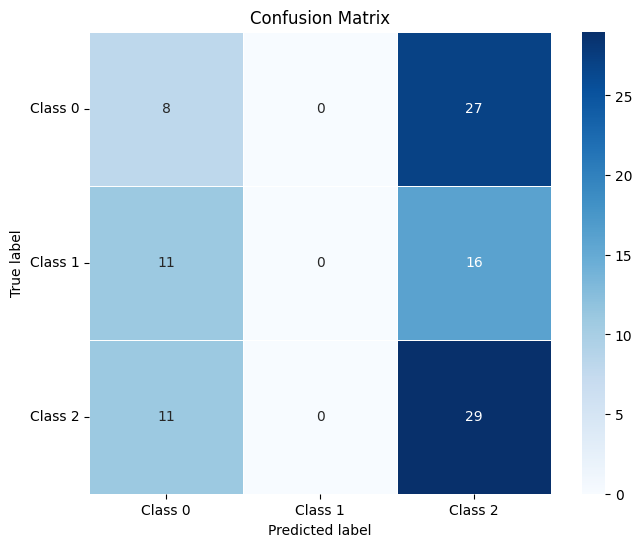

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Given confusion matrix
conf_matrix = total_tscm

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Draw the heatmap
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", square=True, cbar=True, linewidths=.5)

# Adding labels, title, and ticks
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.xticks(np.arange(conf_matrix.shape[1]) + 0.5, labels=["Class 0", "Class 1", "Class 2"])
plt.yticks(np.arange(conf_matrix.shape[0]) + 0.5, labels=["Class 0", "Class 1", "Class 2"], rotation=0)
plt.show()


In [80]:
train_history

{'epoch_loss': [1.1210658726145009, 1.1026816749181905],
 'Accuracy': [0.39344262295081966, 0.3770491803278688],
 'Sensitivity': [0.36904761904761907, 0.3194444444444445],
 'Specificity': [0.6855855855855856, 0.6624624624624625],
 'Precision': [0.26376811594202904, 0.13218390804597702],
 'NPV': [0.7154668567355666, 0.6821807675397275],
 'F1_score': [0.3076503626151917, 0.1869918699186992],
 'AUC': [0.4037698412698412, 0.4559771825396825],
 'AverageAccuracy': [0.5273166023166023, 0.4909534534534535],
 'metric': [(array([[0, 0, 8]]),
   array([[ 0,  0, 13]]),
   array([[7, 6, 0]]),
   array([[14, 15,  0]])),
  (array([[0, 0, 8]]),
   array([[ 0,  0, 13]]),
   array([[7, 6, 0]]),
   array([[14, 15,  0]]))]}

In [ ]:
y_ts, y_ts_pred_argmax, y_ts_pred

In [79]:
len(y_ts_pred_argmax_a)

40

In [78]:
y_ts_pred_argmax_a = torch.cat([y_ts_pred_argmax,y_ts_pred_argmax], dim=-1)

In [64]:
cm1 = confusion_matrix(y_ts, y_ts_pred_argmax)
cm1

array([[0, 0, 7],
       [0, 0, 6],
       [0, 0, 8]], dtype=int64)

In [65]:
cm2 = confusion_matrix(y_ts, y_ts_pred_argmax)
cm1+cm2

array([[ 0,  0, 14],
       [ 0,  0, 12],
       [ 0,  0, 16]], dtype=int64)

In [61]:
metric[0]

array([[0, 0, 8]])

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Your confusion matrix
conf_matrix = list(metric)

# Flatten the matrix if it's 3D (as in your input)
if conf_matrix.ndim == 3:
    conf_matrix = conf_matrix.reshape(conf_matrix.shape[0], conf_matrix.shape[2])

# Set up the matplotlib figure
plt.figure(figsize=(10, 7))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", square=True, cbar_kws={"shrink": .5})

# Labels, title, and ticks
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.xticks(np.arange(conf_matrix.shape[1]) + 0.5, labels=["Class 0", "Class 1", "Class 2"])
plt.yticks(np.arange(conf_matrix.shape[0]) + 0.5, labels=["Class 0", "Class 1", "Class 2", "Class 3"], rotation=0)
plt.show()


AttributeError: 'list' object has no attribute 'ndim'

In [82]:
def get_mean_std(list_w_dicts, metric):
    metric_values = [fold[metric] for fold in list_w_dicts]
    metric_values = list(zip(*metric_values))

    means = [np.mean(epoch) for epoch in metric_values]
    stds = [np.std(epoch) for epoch in metric_values]
    return means, stds

In [55]:
def save_progress(train_history_cv, val_history_cv):
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))

    tr_epoch_loss_m, tr_epoch_loss_std = get_mean_std(train_history_cv, metric="epoch_loss")
    v_epoch_loss_m, v_epoch_loss_std = get_mean_std(val_history_cv, metric='epoch_loss')
    tr_epochs = range(1, len(tr_epoch_loss_m) + 1)
    v_epochs = range(1, len(v_epoch_loss_m) + 1)
    axes[0,0].plot(tr_epochs, tr_epoch_loss_m, label=f'training')
    axes[0,0].plot(v_epochs, v_epoch_loss_m, label=f'validation')
    axes[0,0].fill_between(tr_epochs, np.array(tr_epoch_loss_m)-np.array(tr_epoch_loss_std), np.array(tr_epoch_loss_m)+np.array(tr_epoch_loss_std), alpha=0.3)
    axes[0,0].fill_between(v_epochs, np.array(v_epoch_loss_m)-np.array(v_epoch_loss_std), np.array(v_epoch_loss_m)+np.array(v_epoch_loss_std), alpha=0.3)
    axes[0,0].legend()
    axes[0,0].set_title("Epoch Average Loss")
    axes[0,0].set_xlabel("epoch")

    tr_AUC_m, tr_AUC_sd = get_mean_std(train_history_cv, metric="AUC")
    v_AUC_m, v_AUC_sd = get_mean_std(val_history_cv, metric='AUC')
    tr_epochs = range(1, len(tr_AUC_m) + 1)
    v_epochs = range(1, len(v_AUC_m) + 1)
    axes[0,1].plot(tr_epochs, tr_AUC_m, label=f'training')
    axes[0,1].plot(v_epochs, v_AUC_m, label=f'validation')
    axes[0,1].fill_between(tr_epochs, np.array(tr_AUC_m) - np.array(tr_AUC_sd), np.array(tr_AUC_m) + np.array(tr_AUC_sd), alpha=0.3)
    axes[0,1].fill_between(v_epochs, np.array(v_AUC_m) - np.array(v_AUC_sd), np.array(v_AUC_m) + np.array(v_AUC_sd), alpha=0.3)
    axes[0,1].legend()
    axes[0,1].set_title("AUC")
    axes[0,1].set_xlabel("epoch")
    axes[0,1].set_ylim(bottom=0);

    tr_Accuracy_m, tr_Accuracy_sd = get_mean_std(train_history_cv, metric="Accuracy")
    v_Accuracy_m, v_Accuracy_sd = get_mean_std(val_history_cv, metric='Accuracy')
    tr_epochs = range(1, len(tr_Accuracy_m) + 1)
    v_epochs = range(1, len(v_Accuracy_m) + 1)
    axes[0,2].plot(tr_epochs, tr_Accuracy_m, label=f'training')
    axes[0,2].plot(v_epochs, v_Accuracy_m, label=f'validation')
    axes[0,2].fill_between(tr_epochs, np.array(tr_Accuracy_m) - np.array(tr_Accuracy_sd), np.array(tr_Accuracy_m) + np.array(tr_Accuracy_sd), alpha=0.3)
    axes[0,2].fill_between(v_epochs, np.array(v_Accuracy_m) - np.array(v_Accuracy_sd), np.array(v_Accuracy_m) + np.array(v_Accuracy_sd), alpha=0.3)
    axes[0,2].legend()
    axes[0,2].set_title("Accuracy")
    axes[0,2].set_xlabel("epoch")
    axes[0,2].set_ylim(bottom=0, top=1);

    ## row 2
    tr_Sensitivity_m, tr_Sensitivity_sd = get_mean_std(train_history_cv, metric="Sensitivity")
    v_Sensitivity_m, v_Sensitivity_sd = get_mean_std(val_history_cv, metric='Sensitivity')
    tr_epochs = range(1, len(tr_Sensitivity_m) + 1)
    v_epochs = range(1, len(v_Sensitivity_m) + 1)
    axes[1,0].plot(tr_epochs, tr_Sensitivity_m, label=f'training')
    axes[1,0].plot(v_epochs, v_Sensitivity_m, label=f'validation')
    axes[1,0].fill_between(tr_epochs, np.array(tr_Sensitivity_m) - np.array(tr_Sensitivity_sd), np.array(tr_Sensitivity_m) + np.array(tr_Sensitivity_sd), alpha=0.3)
    axes[1,0].fill_between(v_epochs, np.array(v_Sensitivity_m) - np.array(v_Sensitivity_sd), np.array(v_Sensitivity_m) + np.array(v_Sensitivity_sd), alpha=0.3)
    axes[1,0].legend()
    axes[1,0].set_title("Sensitivity")
    axes[1,0].set_xlabel("epoch")
    axes[1,0].set_ylim(bottom=0, top=1);

    tr_Specificity_m, tr_Specificity_sd = get_mean_std(train_history_cv, metric="Specificity")
    v_Specificity_m, v_Specificity_sd = get_mean_std(val_history_cv, metric='Specificity')
    tr_epochs = range(1, len(tr_Specificity_m) + 1)
    v_epochs = range(1, len(v_Specificity_m) + 1)
    axes[1,1].plot(tr_epochs, tr_Specificity_m, label=f'training')
    axes[1,1].plot(v_epochs, v_Specificity_m, label=f'validation')
    axes[1,1].fill_between(tr_epochs, np.array(tr_Specificity_m) - np.array(tr_Specificity_sd), np.array(tr_Specificity_m) + np.array(tr_Specificity_sd), alpha=0.3)
    axes[1,1].fill_between(v_epochs, np.array(v_Specificity_m) - np.array(v_Specificity_sd), np.array(v_Specificity_m) + np.array(v_Specificity_sd), alpha=0.3)
    axes[1,1].legend()
    axes[1,1].set_title("Specificity")
    axes[1,1].set_xlabel("epoch")
    axes[1,1].set_ylim(bottom=0, top=1);

    tr_Precision_m, tr_Precision_sd = get_mean_std(train_history_cv, metric="Precision")
    v_Precision_m, v_Precision_sd = get_mean_std(val_history_cv, metric='Precision')
    tr_epochs = range(1, len(tr_Precision_m) + 1)
    v_epochs = range(1, len(v_Precision_m) + 1)
    axes[1,2].plot(tr_epochs, tr_Precision_m, label=f'training')
    axes[1,2].plot(v_epochs, v_Precision_m, label=f'validation')
    axes[1,2].fill_between(tr_epochs, np.array(tr_Precision_m) - np.array(tr_Precision_sd), np.array(tr_Precision_m) + np.array(tr_Precision_sd), alpha=0.3)
    axes[1,2].fill_between(v_epochs, np.array(v_Precision_m) - np.array(v_Precision_sd), np.array(v_Precision_m) + np.array(v_Precision_sd), alpha=0.3)
    axes[1,2].legend()
    axes[1,2].set_title("Precision")
    axes[1,2].set_xlabel("epoch")
    axes[1,2].set_ylim(bottom=0, top=1);

    ## row 3
    tr_NPV_m, tr_NPV_sd = get_mean_std(train_history_cv, metric="NPV")
    v_NPV_m, v_NPV_sd = get_mean_std(val_history_cv, metric='NPV')
    tr_epochs = range(1, len(tr_NPV_m) + 1)
    v_epochs = range(1, len(v_NPV_m) + 1)
    axes[2,0].plot(tr_epochs, tr_NPV_m, label=f'training')
    axes[2,0].plot(v_epochs, v_NPV_m, label=f'validation')
    axes[2,0].fill_between(tr_epochs, np.array(tr_NPV_m) - np.array(tr_NPV_sd), np.array(tr_NPV_m) + np.array(tr_NPV_sd), alpha=0.3)
    axes[2,0].fill_between(v_epochs, np.array(v_NPV_m) - np.array(v_NPV_sd), np.array(v_NPV_m) + np.array(v_NPV_sd), alpha=0.3)
    axes[2,0].legend()
    axes[2,0].set_title("NPV")
    axes[2,0].set_xlabel("epoch")
    axes[2,0].set_ylim(bottom=0, top=1);

    tr_F1_score_m, tr_F1_score_sd = get_mean_std(train_history_cv, metric="F1_score")
    v_F1_score_m, v_F1_score_sd = get_mean_std(val_history_cv, metric='F1_score')
    tr_epochs = range(1, len(tr_F1_score_m) + 1)
    v_epochs = range(1, len(v_F1_score_m) + 1)
    axes[2,1].plot(tr_epochs, tr_F1_score_m, label=f'training')
    axes[2,1].plot(v_epochs, v_F1_score_m, label=f'validation')
    axes[2,1].fill_between(tr_epochs, np.array(tr_F1_score_m) - np.array(tr_F1_score_sd), np.array(tr_F1_score_m) + np.array(tr_F1_score_sd), alpha=0.3)
    axes[2,1].fill_between(v_epochs, np.array(v_F1_score_m) - np.array(v_F1_score_sd), np.array(v_F1_score_m) + np.array(v_F1_score_sd), alpha=0.3)
    axes[2,1].legend()
    axes[2,1].set_title("F1_score")
    axes[2,1].set_xlabel("epoch")
    axes[2,1].set_ylim(bottom=0, top=1);

    tr_AverageAccuracy_m, tr_AverageAccuracy_sd = get_mean_std(train_history_cv, metric="AverageAccuracy")
    v_AverageAccuracy_m, v_AverageAccuracy_sd = get_mean_std(val_history_cv, metric='AverageAccuracy')
    tr_epochs = range(1, len(tr_AverageAccuracy_m) + 1)
    v_epochs = range(1, len(v_AverageAccuracy_m) + 1)
    axes[2,2].plot(tr_epochs, tr_AverageAccuracy_m, label=f'training')
    axes[2,2].plot(v_epochs, v_AverageAccuracy_m, label=f'validation')
    axes[2,2].fill_between(tr_epochs, np.array(tr_AverageAccuracy_m) - np.array(tr_AverageAccuracy_sd), np.array(tr_AverageAccuracy_m) + np.array(tr_AverageAccuracy_sd), alpha=0.3)
    axes[2,2].fill_between(v_epochs, np.array(v_AverageAccuracy_m) - np.array(v_AverageAccuracy_sd), np.array(v_AverageAccuracy_m) + np.array(v_AverageAccuracy_sd), alpha=0.3)
    axes[2,2].legend()
    axes[2,2].set_title("Average Accuracy")
    axes[2,2].set_xlabel("epoch")
    axes[2,2].set_ylim(bottom=0, top=1);

    if not os.path.exists(os.path.join(model_dir, "snap")):
        os.mkdir(os.path.join(model_dir, "snap"))
    save_dir = os.path.join(model_dir, "snap", attempt + "_cv_snap.png")
    plt.savefig(save_dir)

In [85]:
model_dir

'c:\\Users\\Yin\\Desktop\\Vrije_courses\\internship\\codes\\data\\BLT_radiomics\\models\\densenet'

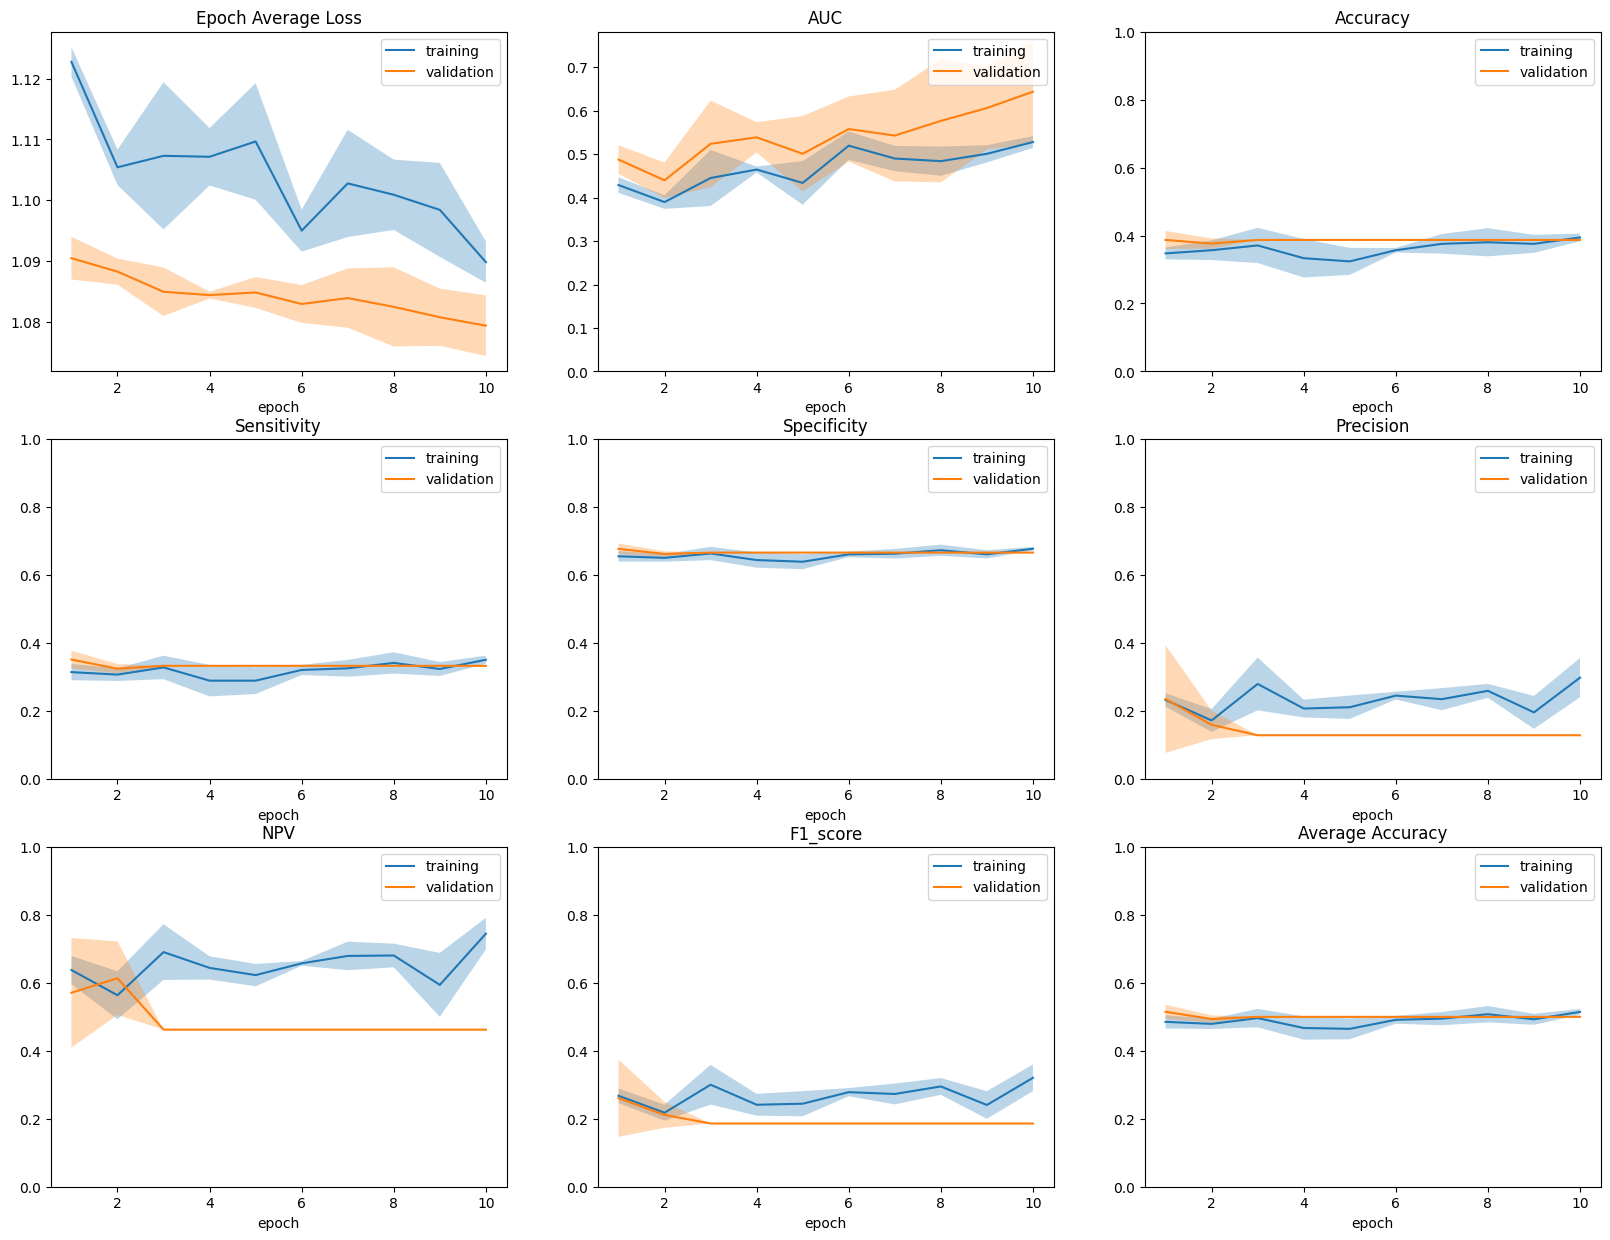

In [251]:
fig, axes = plt.subplots(3, 3, figsize=(20, 15))

tr_epoch_loss_m, tr_epoch_loss_std = get_mean_std(train_history_cv, metric="epoch_loss")
v_epoch_loss_m, v_epoch_loss_std = get_mean_std(val_history_cv, metric='epoch_loss')
tr_epochs = range(1, len(tr_epoch_loss_m) + 1)
v_epochs = range(1, len(v_epoch_loss_m) + 1)
axes[0,0].plot(tr_epochs, tr_epoch_loss_m, label=f'training')
axes[0,0].plot(v_epochs, v_epoch_loss_m, label=f'validation')
axes[0,0].fill_between(tr_epochs, np.array(tr_epoch_loss_m)-np.array(tr_epoch_loss_std), np.array(tr_epoch_loss_m)+np.array(tr_epoch_loss_std), alpha=0.3)
axes[0,0].fill_between(v_epochs, np.array(v_epoch_loss_m)-np.array(v_epoch_loss_std), np.array(v_epoch_loss_m)+np.array(v_epoch_loss_std), alpha=0.3)
axes[0,0].legend()
axes[0,0].set_title("Epoch Average Loss")
axes[0,0].set_xlabel("epoch")

tr_AUC_m, tr_AUC_sd = get_mean_std(train_history_cv, metric="AUC")
v_AUC_m, v_AUC_sd = get_mean_std(val_history_cv, metric='AUC')
tr_epochs = range(1, len(tr_AUC_m) + 1)
v_epochs = range(1, len(v_AUC_m) + 1)
axes[0,1].plot(tr_epochs, tr_AUC_m, label=f'training')
axes[0,1].plot(v_epochs, v_AUC_m, label=f'validation')
axes[0,1].fill_between(tr_epochs, np.array(tr_AUC_m) - np.array(tr_AUC_sd), np.array(tr_AUC_m) + np.array(tr_AUC_sd), alpha=0.3)
axes[0,1].fill_between(v_epochs, np.array(v_AUC_m) - np.array(v_AUC_sd), np.array(v_AUC_m) + np.array(v_AUC_sd), alpha=0.3)
axes[0,1].legend()
axes[0,1].set_title("AUC")
axes[0,1].set_xlabel("epoch")
axes[0,1].set_ylim(bottom=0);

tr_Accuracy_m, tr_Accuracy_sd = get_mean_std(train_history_cv, metric="Accuracy")
v_Accuracy_m, v_Accuracy_sd = get_mean_std(val_history_cv, metric='Accuracy')
tr_epochs = range(1, len(tr_Accuracy_m) + 1)
v_epochs = range(1, len(v_Accuracy_m) + 1)
axes[0,2].plot(tr_epochs, tr_Accuracy_m, label=f'training')
axes[0,2].plot(v_epochs, v_Accuracy_m, label=f'validation')
axes[0,2].fill_between(tr_epochs, np.array(tr_Accuracy_m) - np.array(tr_Accuracy_sd), np.array(tr_Accuracy_m) + np.array(tr_Accuracy_sd), alpha=0.3)
axes[0,2].fill_between(v_epochs, np.array(v_Accuracy_m) - np.array(v_Accuracy_sd), np.array(v_Accuracy_m) + np.array(v_Accuracy_sd), alpha=0.3)
axes[0,2].legend()
axes[0,2].set_title("Accuracy")
axes[0,2].set_xlabel("epoch")
axes[0,2].set_ylim(bottom=0, top=1);

## row 2
tr_Sensitivity_m, tr_Sensitivity_sd = get_mean_std(train_history_cv, metric="Sensitivity")
v_Sensitivity_m, v_Sensitivity_sd = get_mean_std(val_history_cv, metric='Sensitivity')
tr_epochs = range(1, len(tr_Sensitivity_m) + 1)
v_epochs = range(1, len(v_Sensitivity_m) + 1)
axes[1,0].plot(tr_epochs, tr_Sensitivity_m, label=f'training')
axes[1,0].plot(v_epochs, v_Sensitivity_m, label=f'validation')
axes[1,0].fill_between(tr_epochs, np.array(tr_Sensitivity_m) - np.array(tr_Sensitivity_sd), np.array(tr_Sensitivity_m) + np.array(tr_Sensitivity_sd), alpha=0.3)
axes[1,0].fill_between(v_epochs, np.array(v_Sensitivity_m) - np.array(v_Sensitivity_sd), np.array(v_Sensitivity_m) + np.array(v_Sensitivity_sd), alpha=0.3)
axes[1,0].legend()
axes[1,0].set_title("Sensitivity")
axes[1,0].set_xlabel("epoch")
axes[1,0].set_ylim(bottom=0, top=1);

tr_Specificity_m, tr_Specificity_sd = get_mean_std(train_history_cv, metric="Specificity")
v_Specificity_m, v_Specificity_sd = get_mean_std(val_history_cv, metric='Specificity')
tr_epochs = range(1, len(tr_Specificity_m) + 1)
v_epochs = range(1, len(v_Specificity_m) + 1)
axes[1,1].plot(tr_epochs, tr_Specificity_m, label=f'training')
axes[1,1].plot(v_epochs, v_Specificity_m, label=f'validation')
axes[1,1].fill_between(tr_epochs, np.array(tr_Specificity_m) - np.array(tr_Specificity_sd), np.array(tr_Specificity_m) + np.array(tr_Specificity_sd), alpha=0.3)
axes[1,1].fill_between(v_epochs, np.array(v_Specificity_m) - np.array(v_Specificity_sd), np.array(v_Specificity_m) + np.array(v_Specificity_sd), alpha=0.3)
axes[1,1].legend()
axes[1,1].set_title("Specificity")
axes[1,1].set_xlabel("epoch")
axes[1,1].set_ylim(bottom=0, top=1);

tr_Precision_m, tr_Precision_sd = get_mean_std(train_history_cv, metric="Precision")
v_Precision_m, v_Precision_sd = get_mean_std(val_history_cv, metric='Precision')
tr_epochs = range(1, len(tr_Precision_m) + 1)
v_epochs = range(1, len(v_Precision_m) + 1)
axes[1,2].plot(tr_epochs, tr_Precision_m, label=f'training')
axes[1,2].plot(v_epochs, v_Precision_m, label=f'validation')
axes[1,2].fill_between(tr_epochs, np.array(tr_Precision_m) - np.array(tr_Precision_sd), np.array(tr_Precision_m) + np.array(tr_Precision_sd), alpha=0.3)
axes[1,2].fill_between(v_epochs, np.array(v_Precision_m) - np.array(v_Precision_sd), np.array(v_Precision_m) + np.array(v_Precision_sd), alpha=0.3)
axes[1,2].legend()
axes[1,2].set_title("Precision")
axes[1,2].set_xlabel("epoch")
axes[1,2].set_ylim(bottom=0, top=1);

## row 3
tr_NPV_m, tr_NPV_sd = get_mean_std(train_history_cv, metric="NPV")
v_NPV_m, v_NPV_sd = get_mean_std(val_history_cv, metric='NPV')
tr_epochs = range(1, len(tr_NPV_m) + 1)
v_epochs = range(1, len(v_NPV_m) + 1)
axes[2,0].plot(tr_epochs, tr_NPV_m, label=f'training')
axes[2,0].plot(v_epochs, v_NPV_m, label=f'validation')
axes[2,0].fill_between(tr_epochs, np.array(tr_NPV_m) - np.array(tr_NPV_sd), np.array(tr_NPV_m) + np.array(tr_NPV_sd), alpha=0.3)
axes[2,0].fill_between(v_epochs, np.array(v_NPV_m) - np.array(v_NPV_sd), np.array(v_NPV_m) + np.array(v_NPV_sd), alpha=0.3)
axes[2,0].legend()
axes[2,0].set_title("NPV")
axes[2,0].set_xlabel("epoch")
axes[2,0].set_ylim(bottom=0, top=1);

tr_F1_score_m, tr_F1_score_sd = get_mean_std(train_history_cv, metric="F1_score")
v_F1_score_m, v_F1_score_sd = get_mean_std(val_history_cv, metric='F1_score')
tr_epochs = range(1, len(tr_F1_score_m) + 1)
v_epochs = range(1, len(v_F1_score_m) + 1)
axes[2,1].plot(tr_epochs, tr_F1_score_m, label=f'training')
axes[2,1].plot(v_epochs, v_F1_score_m, label=f'validation')
axes[2,1].fill_between(tr_epochs, np.array(tr_F1_score_m) - np.array(tr_F1_score_sd), np.array(tr_F1_score_m) + np.array(tr_F1_score_sd), alpha=0.3)
axes[2,1].fill_between(v_epochs, np.array(v_F1_score_m) - np.array(v_F1_score_sd), np.array(v_F1_score_m) + np.array(v_F1_score_sd), alpha=0.3)
axes[2,1].legend()
axes[2,1].set_title("F1_score")
axes[2,1].set_xlabel("epoch")
axes[2,1].set_ylim(bottom=0, top=1);

tr_AverageAccuracy_m, tr_AverageAccuracy_sd = get_mean_std(train_history_cv, metric="AverageAccuracy")
v_AverageAccuracy_m, v_AverageAccuracy_sd = get_mean_std(val_history_cv, metric='AverageAccuracy')
tr_epochs = range(1, len(tr_AverageAccuracy_m) + 1)
v_epochs = range(1, len(v_AverageAccuracy_m) + 1)
axes[2,2].plot(tr_epochs, tr_AverageAccuracy_m, label=f'training')
axes[2,2].plot(v_epochs, v_AverageAccuracy_m, label=f'validation')
axes[2,2].fill_between(tr_epochs, np.array(tr_AverageAccuracy_m) - np.array(tr_AverageAccuracy_sd), np.array(tr_AverageAccuracy_m) + np.array(tr_AverageAccuracy_sd), alpha=0.3)
axes[2,2].fill_between(v_epochs, np.array(v_AverageAccuracy_m) - np.array(v_AverageAccuracy_sd), np.array(v_AverageAccuracy_m) + np.array(v_AverageAccuracy_sd), alpha=0.3)
axes[2,2].legend()
axes[2,2].set_title("Average Accuracy")
axes[2,2].set_xlabel("epoch")
axes[2,2].set_ylim(bottom=0, top=1);

save_dir = os.path.join(model_dir, "snap", attempt + "_cv_snap.png")
plt.savefig(save_dir)

In [225]:
len(val_history_cv)

3

In [184]:
train_history_cv
val_history_cv
best_metrics
best_models
final_models

[DenseNet121(
   (features): Sequential(
     (conv0): Conv3d(5, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
     (norm0): InstanceNorm3d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
     (relu0): ReLU(inplace=True)
     (pool0): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
     (denseblock1): _DenseBlock(
       (denselayer1): _DenseLayer(
         (layers): Sequential(
           (norm1): InstanceNorm3d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
           (relu1): ReLU(inplace=True)
           (conv1): Conv3d(64, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
           (norm2): InstanceNorm3d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
           (relu2): ReLU(inplace=True)
           (conv2): Conv3d(128, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
         )
       )
       (denselayer2): _DenseLayer

In [117]:
# train_transforms = Compose([
#     EnsureChannelFirst(), Resize((78,78,31)),
#     # Data augmentation
#     RandRotate(range_z = 0.35, prob = 0.3), RandFlip(prob = 0.5), 
#     RandGaussianNoise(std=0.05, prob=0.5),
#     RandZoom(prob = 0.3, min_zoom=1.0, max_zoom=1.2), ToTensor()])
# val_transforms = Compose([EnsureChannelFirst(), Resize((78,78,31))])

# ####################
# ## Cross validation 
# kfold = 5

# sss = StratifiedShuffleSplit(n_splits=kfold, test_size=0.3, random_state=42)
# for fold, (train_idx, val_idx) in enumerate(sss.split(images, labels)):
#     train_x = [images[i] for i in train_idx]
#     train_seg = [segs[i] for i in train_idx]
#     train_y = [labels[i] for i in train_idx]

#     val_x = [images[i] for i in val_idx]
#     val_seg = [segs[i] for i in val_idx]
#     val_y = [labels[i] for i in val_idx]
#     print(f"Fold: {fold}")
#     print(f"Training count: {len(train_x)}, Test count: {len(val_x)}")
#     check_dataoverlap(train_x, val_x)
#     # print(train_idx)
#     # print(test_idx)

Fold: 0
Training count: 71, Test count: 31
The data have no overlapping elements.
Fold: 1
Training count: 71, Test count: 31
The data have no overlapping elements.
Fold: 2
Training count: 71, Test count: 31
The data have no overlapping elements.
Fold: 3
Training count: 71, Test count: 31
The data have no overlapping elements.
Fold: 4
Training count: 71, Test count: 31
The data have no overlapping elements.


In [118]:
# Define transforms
train_transforms = Compose([
    EnsureChannelFirst(), Resize((78,78,31)),
    # Data augmentation
    RandRotate(range_z = 0.35, prob = 0.3), RandFlip(prob = 0.5), 
    RandGaussianNoise(std=0.05, prob=0.5),
    RandZoom(prob = 0.3, min_zoom=1.0, max_zoom=1.2), ToTensor()])
val_transforms = Compose([EnsureChannelFirst(), Resize((78,78,31))])
y_trans = Compose([AsDiscrete(to_onehot=num_class)])
y_pred_trans = Compose([Activations(softmax=True)])

# # Define image dataset, data loader
# check_ds = ImageDataset(image_files=images, seg_files=segs, labels=labels,
#                         transform=train_transforms, seg_transform=train_transforms)
# check_loader = DataLoader(check_ds, batch_size=15, num_workers=2, pin_memory=torch.cuda.is_available())
# # check the data
# im, seg, label = monai.utils.misc.first(check_loader)
# print(type(im), im.shape, seg.shape, label)

# create a training data loader
train_ds = ImageDataset(image_files=train_x, seg_files=train_seg, labels=train_y,
                        transform=train_transforms, seg_transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())

# create a validation data loader
val_ds = ImageDataset(image_files=val_x, seg_files=val_seg, labels=val_y, 
                      transform=val_transforms, seg_transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=2, pin_memory=torch.cuda.is_available())

# create a test data loader
# test_ds = ImageDataset(image_files=test_x, seg_files=test_seg, labels=test_y, 
#                        transform=val_transforms, seg_transform=val_transforms)
# test_loader = DataLoader(test_ds, batch_size=1, num_workers=2, pin_memory=torch.cuda.is_available())

## Archive

In [53]:
# # OLD ONE
# random_state = np.random.RandomState()
# sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)
# train_val_idx, test_idx = next(sss1.split(list(range(len(images))), labels))

# # Further split train+val into train and val sets
# sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=random_state)  # 0.25 x 0.8 = 0.2
# train_idx, val_idx = next(sss2.split(train_val_idx, [labels[i] for i in train_val_idx]))

# seed = random_state.get_state()[1][0]
# print(f"Random state seed used: {seed}")

# # Adjust indices to original dataset
# train_idx = [train_val_idx[i] for i in train_idx]
# val_idx = [train_val_idx[i] for i in val_idx]

# train_x = [images[i] for i in train_idx]
# train_seg = [segs[i] for i in train_idx]
# train_y = [labels[i] for i in train_idx]

# val_x = [images[i] for i in val_idx]
# val_seg = [segs[i] for i in val_idx]
# val_y = [labels[i] for i in val_idx]

# test_x = [images[i] for i in test_idx]
# test_seg = [segs[i] for i in test_idx]
# test_y = [labels[i] for i in test_idx]
# check_dataoverlap(train_x, val_x, test_x)
# print(f"Training count: {len(train_x)}, Validation count: " f"{len(val_x)}, Test count: {len(test_x)}")

Random state seed used: 76915698
The data have no overlapping elements.
Training count: 60, Validation count: 21, Test count: 21


In [119]:
# train_labels_counts = list()
# for i in range(len(train_idx)):
#     train_labels_counts.append(labels[i])
#     train_counter = [t.item() for t in train_labels_counts]
# print(f"training set: {Counter(train_counter)}")

# val_labels_counts = list()
# for i in range(len(val_idx)):
#     val_labels_counts.append(labels[i])
#     val_counter = [t.item() for t in val_labels_counts]
# print(f"validation set: {Counter(val_counter)}")

# test_labels_counts = list()
# for i in range(len(test_idx)):
#     test_labels_counts.append(labels[i])
#     test_counter = [t.item() for t in test_labels_counts]
# print(f"testing set: {Counter(test_counter)}")

training set: Counter({0: 32, 2: 26, 1: 13})
validation set: Counter({2: 13, 0: 12, 1: 6})


In [26]:
# # load a single image to get the shape
# im = sitk.ReadImage(images[0])
# im = im.GetSize()
# print('im.shape: ', im)

# # get shape mask
# mask = sitk.ReadImage(segs[0])
# arr_mask = sitk.GetArrayFromImage(mask)
# mask = mask.GetSize()
# print('mask.shape: ', mask)
# print(f'mask values: {np.unique(arr_mask)}')

In [28]:
# # Visualization
# for batch_data in train_loader:
#     train_images, train_segs, train_labels = (
#         batch_data[0].to(device), 
#         batch_data[1].to(device), 
#         batch_data[2].to(device)
#     )
#     masked_train_images = torch.cat((train_images,train_segs[:,0:1,:,:]), dim=1)
#     print(masked_train_images.shape)
#     selected_image = masked_train_images[0]
#     phases_list = {0:"Precontrast phase",
#                 1:"Arterial phase",
#                 2:"Portal venous phase",
#                 3:"Delayed phase"}

#     fig, axes = plt.subplots(1, 4, figsize=(20, 4))
#     for i in range(4):
#         ax = axes[i]
#         ax.imshow(selected_image[i, :, :, 10], cmap='gray')
#         ax.imshow(selected_image[4, :, :, 10], alpha=0.2)
#         ax.set_title(phases_list[i])
#         ax.axis("off")

#     plt.show()
#     break

learning rate scheduler

In [29]:
# from torch.optim import lr_scheduler
# lambda1 = lambda epoch: 0.98 ** epoch
# scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

In [30]:
# lrs = []

# for i in range(100):
#     optimizer.step()
#     lrs.append(optimizer.param_groups[0]["lr"])
#     scheduler.step()

# plt.plot(range(100),lrs)

## Training

In [120]:
# Create DenseNet121, CrossEntropyLoss and Adam optimizer
model = monai.networks.nets.DenseNet121(spatial_dims=3, in_channels=5, out_channels=num_class, norm='instance').to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
auc_metric = ROCAUCMetric()
use_ema = True
if use_ema:
    ema = EMA(
    model,
    beta = 0.9999, #0.9999,   # exponential moving average factor
    update_after_step = 5,    # only after this number of .update() calls will it start updating
    update_every = 5,         # how often to actually update, to save on compute (updates every 10th .update() call)
    )
    ema.update()

In [ ]:
# from torchsummary import summary
# summary(model, input_size=(5, 78,78,31))

In [123]:
for file in os.listdir(model_dir):
    if attempt in file:
        raise ValueError("The model already exists")

max_epochs = 2
val_interval = 1
best_metric = -1
best_metric_epoch = -1
writer = SummaryWriter()

# store the data
train_history = empty_history_dict()
val_history = empty_history_dict()

for epoch in range(max_epochs):
    print("-" * 15)
    print(f"epoch {epoch + 1}/{max_epochs}")
    print("#"*3+" Training")
    model.train()
    
    epoch_loss = 0
    step = 0
    y, y_pred, y_pred_argmax = create_empty_predict_lists(device)

    for batch_data in train_loader:
        step += 1
        train_images, train_segs, train_labels = (
            batch_data[0].to(device), 
            batch_data[1].to(device), 
            batch_data[2].to(device))
        masked_train_images = torch.cat((train_images,train_segs[:,0:1,:,:]), dim=1) 
        
        # forward and backward pass
        optimizer.zero_grad()
        train_pred = model(masked_train_images)
        train_pred_argmax = train_pred.argmax(dim=1)
        loss = loss_function(train_pred, train_labels)
        loss.backward()
        optimizer.step()
        ema.update()
        epoch_loss += loss.item()
        
        epoch_len = len(train_ds) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        
        # append the predicted value
        y = torch.cat([y, train_labels], dim=0)
        y_pred = torch.cat([y_pred, train_pred], dim=0)
        y_pred_argmax = torch.cat([y_pred_argmax, train_pred_argmax], dim=0)
    
    Accuracy, Sensitivity, Specificity, Precision, NPV, F1_score, AUC, AverageAccuracy, metric = performance_multiclass(y, y_pred_argmax, y_pred)
    train_history = append_metrics(train_history, Accuracy, Sensitivity, Specificity, Precision, NPV, F1_score, AUC, AverageAccuracy, metric)
    # auc_value = calaulate_auc(y, y_pred, y_trans, y_pred_trans)
    # metric, avg_sensitivity, avg_specificity = calaulate_metric(y, y_pred_argmax)
    # train_history["AUC"].append(auc_value)
    # train_history["metric"].append(metric)
    # train_history["sensitivity"].append(avg_sensitivity)
    # train_history["specificity"].append(avg_specificity)
    
    print(f"step: {step}")
    epoch_loss /= step
    train_history["epoch_loss"].append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    if epoch+1 == max_epochs:
        save_model = os.path.join(model_dir, attempt+"_finalepoch.pth")
        torch.save(model.state_dict(), save_model)
        print(f"Save the final model: {attempt}_finalepoch.pth")
    
    ####################
    ## Validation / Testing
    if (epoch + 1) % val_interval == 0:
        print("#"*3+" Validation")
        # ema.apply_shadow()
        model.eval()
        
        v_epoch_loss = 0
        v_step = 0
        y_val, y_val_pred, y_val_pred_argmax = create_empty_predict_lists(device)
        
        with torch.no_grad():
            for val_data in val_loader:
                v_step += 1
                val_images, val_segs, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                    val_data[2].to(device))
                masked_val_images = torch.cat((val_images,val_segs[:,0:1,:,:]), dim=1)
                
                # forward
                val_pred = model(masked_val_images)
                if use_ema:
                    val_pred = ema(masked_val_images)
                val_pred_argmax = val_pred.argmax(dim=1)
                v_loss = loss_function(val_pred, val_labels)
                v_epoch_loss += v_loss.item()

                # append value to the lists
                y_val = torch.cat([y_val, val_labels], dim=0)
                y_val_pred = torch.cat([y_val_pred, val_pred], dim=0)
                y_val_pred_argmax = torch.cat([y_val_pred_argmax, val_pred_argmax], dim=0)
            vAccuracy, vSensitivity, vSpecificity, vPrecision, vNPV, vF1_score, vAUC, vAverageAccuracy, vmetric = performance_multiclass(y_val, y_val_pred_argmax, y_val_pred)
            val_history = append_metrics(val_history, vAccuracy, vSensitivity, vSpecificity, vPrecision, vNPV, vF1_score, vAUC, vAverageAccuracy, vmetric)
            print(f"v_step: {v_step}")
            v_epoch_loss /= v_step
            val_history["epoch_loss"].append(v_epoch_loss)
            
            if vAUC > best_metric:
                best_metric = vAUC
                best_metric_epoch = epoch + 1
                save_model = os.path.join(model_dir, attempt+"_bestauc.pth")
                torch.save(model.state_dict(), save_model)
                print(f"Save new best metric model: {attempt}_bestauc.pth")
            print(f"Current epoch: {epoch+1}, AUC: {vAUC:.4f}")
            print(f"Sensitivity: {vAUC:.4f}, Specificity: {AUC:.4f}")
            print(f"Best AUC: {best_metric:.4f} at epoch {best_metric_epoch}")
            writer.add_scalar("val_AUC", vAUC, epoch + 1)
            
    
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

---------------
epoch 1/2
### Training
1/71, train_loss: 1.0361
2/71, train_loss: 1.3788
3/71, train_loss: 0.9425
4/71, train_loss: 0.9198
5/71, train_loss: 1.0739
6/71, train_loss: 1.3645
7/71, train_loss: 1.3670
8/71, train_loss: 1.3338
9/71, train_loss: 1.0954
10/71, train_loss: 1.0615
11/71, train_loss: 1.0713
12/71, train_loss: 0.9611
13/71, train_loss: 1.2957
14/71, train_loss: 0.9606
15/71, train_loss: 0.9815
16/71, train_loss: 1.2716
17/71, train_loss: 0.9830
18/71, train_loss: 1.0931
19/71, train_loss: 1.2425
20/71, train_loss: 1.0999
21/71, train_loss: 1.0879
22/71, train_loss: 1.0087
23/71, train_loss: 1.0159
24/71, train_loss: 1.0099
25/71, train_loss: 0.9948
26/71, train_loss: 0.9786
27/71, train_loss: 0.9820
28/71, train_loss: 1.0831
29/71, train_loss: 1.1360
30/71, train_loss: 0.9143
31/71, train_loss: 0.8928
32/71, train_loss: 0.9093
33/71, train_loss: 0.8473
34/71, train_loss: 1.1690
35/71, train_loss: 0.8182
36/71, train_loss: 1.1684
37/71, train_loss: 1.4535
38/71, t

invalid value encountered in divide
invalid value encountered in divide


step: 71
epoch 1 average loss: 1.1096
### Validation


invalid value encountered in divide
invalid value encountered in divide


v_step: 31
Save new best metric model: 2024-016-43_bestauc.pth
Current epoch: 1, AUC: 0.4656
Sensitivity: 0.4656, Specificity: 0.3859
Best AUC: 0.4656 at epoch 1
---------------
epoch 2/2
### Training
1/71, train_loss: 1.0618
2/71, train_loss: 1.3025
3/71, train_loss: 1.2636
4/71, train_loss: 1.0151
5/71, train_loss: 1.0345
6/71, train_loss: 1.0297
7/71, train_loss: 1.0179
8/71, train_loss: 1.2412
9/71, train_loss: 1.0032
10/71, train_loss: 0.9713
11/71, train_loss: 1.2409
12/71, train_loss: 0.9533
13/71, train_loss: 1.2258
14/71, train_loss: 1.1613
15/71, train_loss: 0.9644
16/71, train_loss: 0.9127
17/71, train_loss: 1.2041
18/71, train_loss: 0.9022
19/71, train_loss: 1.2995
20/71, train_loss: 1.3110
21/71, train_loss: 1.1795
22/71, train_loss: 1.1727
23/71, train_loss: 1.3362
24/71, train_loss: 1.3381
25/71, train_loss: 1.3018
26/71, train_loss: 1.3049
27/71, train_loss: 1.2554
28/71, train_loss: 0.9150
29/71, train_loss: 1.2258
30/71, train_loss: 1.1909
31/71, train_loss: 0.9345
32

invalid value encountered in divide


step: 71
epoch 2 average loss: 1.1267
Save the final model: 2024-016-43_finalepoch.pth
### Validation
v_step: 31
Save new best metric model: 2024-016-43_bestauc.pth
Current epoch: 2, AUC: 0.5279
Sensitivity: 0.5279, Specificity: 0.4440
Best AUC: 0.5279 at epoch 2
train completed, best_metric: 0.5279 at epoch: 2


invalid value encountered in divide
invalid value encountered in divide


In [174]:
TP, FP, FN, TN = train_history['metric'][best_metric_epoch-1]
results = np.vstack((TP, FP, FN, TN)).T
results_df = pd.DataFrame(results, columns=["TP", "FP", "FN", "TN"])
results_df.index = ["HCA","FNH","HCC"]
def calculate_sensitivity_specificity(row):
    tp, fp, fn, tn = row["TP"], row["FP"], row["FN"], row["TN"]
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    return pd.Series([sensitivity, specificity])

# Calculate and append sensitivity and specificity
results_df[['Sensitivity', 'Specificity']] = results_df.apply(calculate_sensitivity_specificity, axis=1)
results_df = results_df.round(4)
# Display the DataFrame
results_df

,TP,FP,FN,TN,Sensitivity,Specificity
HCA,10,21,14,26,0.4167,0.5532
FNH,0,0,19,52,0.0000,1.0000
HCC,15,25,13,18,0.5357,0.4186


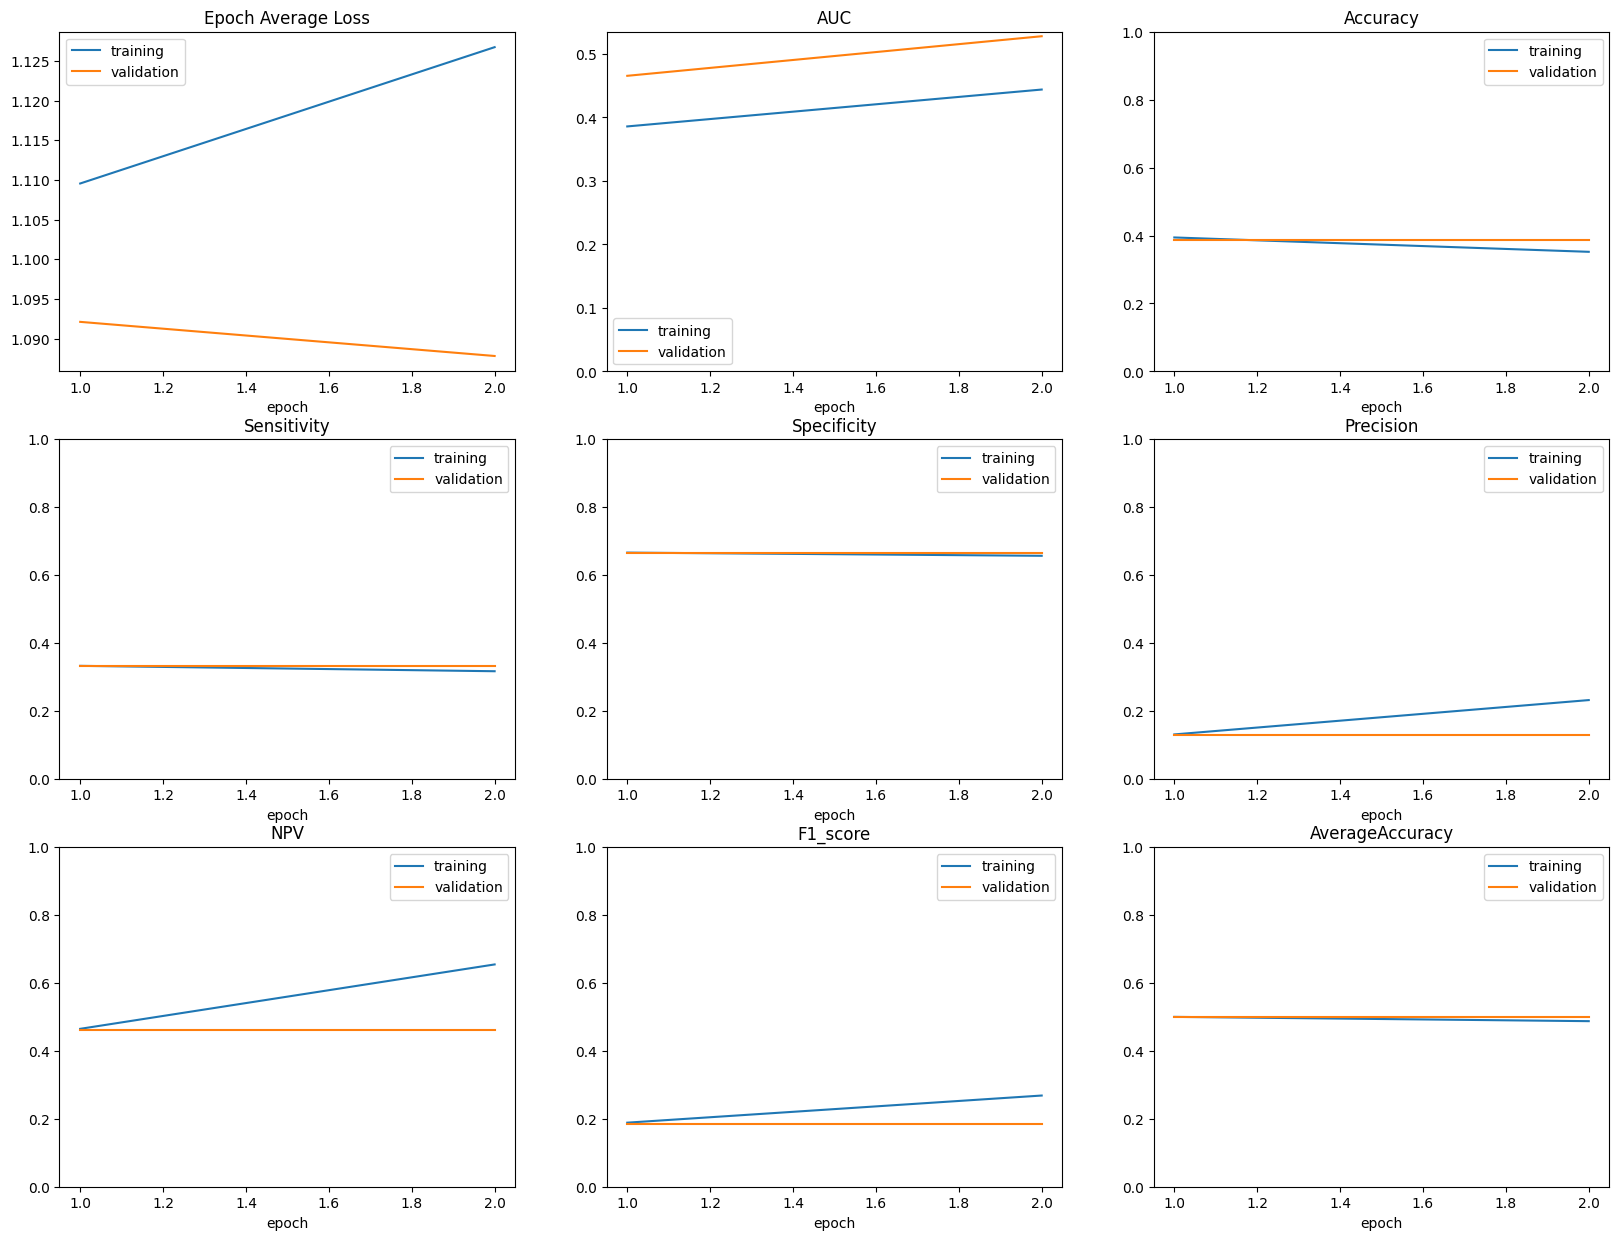

In [134]:
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
x = [i + 1 for i in range(len(train_history["epoch_loss"]))]
y1 = train_history["epoch_loss"]
y2 = val_history["epoch_loss"]
axes[0,0].plot(x, y1, label="training")
axes[0,0].plot(x, y2, label="validation")
axes[0,0].legend()
axes[0,0].set_title("Epoch Average Loss")
axes[0,0].set_xlabel("epoch")

x = [val_interval * (i + 1) for i in range(len(train_history["AUC"]))]
y1 = train_history["AUC"]
y2 = val_history["AUC"]
axes[0,1].plot(x, y1, label="training")
axes[0,1].plot(x, y2, label="validation")
axes[0,1].legend()
axes[0,1].set_title("AUC")
axes[0,1].set_xlabel("epoch")
axes[0,1].set_ylim(bottom=0);

x = [val_interval * (i + 1) for i in range(len(train_history["Accuracy"]))]
y1 = train_history["Accuracy"]
y2 = val_history["Accuracy"]
axes[0,2].plot(x, y1, label="training")
axes[0,2].plot(x, y2, label="validation")
axes[0,2].legend()
axes[0,2].set_title("Accuracy")
axes[0,2].set_xlabel("epoch")
axes[0,2].set_ylim(bottom=0, top=1);

## row 2
x = [val_interval * (i + 1) for i in range(len(train_history["Sensitivity"]))]
y1 = train_history["Sensitivity"]
y2 = val_history["Sensitivity"]
axes[1,0].plot(x, y1, label="training")
axes[1,0].plot(x, y2, label="validation")
axes[1,0].legend()
axes[1,0].set_title("Sensitivity")
axes[1,0].set_xlabel("epoch")
axes[1,0].set_ylim(bottom=0, top=1);

x = [val_interval * (i + 1) for i in range(len(train_history["Specificity"]))]
y1 = train_history["Specificity"]
y2 = val_history["Specificity"]
axes[1,1].plot(x, y1, label="training")
axes[1,1].plot(x, y2, label="validation")
axes[1,1].legend()
axes[1,1].set_title("Specificity")
axes[1,1].set_xlabel("epoch")
axes[1,1].set_ylim(bottom=0, top=1);

x = [val_interval * (i + 1) for i in range(len(train_history["Precision"]))]
y1 = train_history["Precision"]
y2 = val_history["Precision"]
axes[1,2].plot(x, y1, label="training")
axes[1,2].plot(x, y2, label="validation")
axes[1,2].legend()
axes[1,2].set_title("Precision")
axes[1,2].set_xlabel("epoch")
axes[1,2].set_ylim(bottom=0, top=1);

## row 3
x = [val_interval * (i + 1) for i in range(len(train_history["NPV"]))]
y1 = train_history["NPV"]
y2 = val_history["NPV"]
axes[2,0].plot(x, y1, label="training")
axes[2,0].plot(x, y2, label="validation")
axes[2,0].legend()
axes[2,0].set_title("NPV")
axes[2,0].set_xlabel("epoch")
axes[2,0].set_ylim(bottom=0, top=1);

x = [val_interval * (i + 1) for i in range(len(train_history["F1_score"]))]
y1 = train_history["F1_score"]
y2 = val_history["F1_score"]
axes[2,1].plot(x, y1, label="training")
axes[2,1].plot(x, y2, label="validation")
axes[2,1].legend()
axes[2,1].set_title("F1_score")
axes[2,1].set_xlabel("epoch")
axes[2,1].set_ylim(bottom=0, top=1);

x = [val_interval * (i + 1) for i in range(len(train_history["AverageAccuracy"]))]
y1 = train_history["AverageAccuracy"]
y2 = val_history["AverageAccuracy"]
axes[2,2].plot(x, y1, label="training")
axes[2,2].plot(x, y2, label="validation")
axes[2,2].legend()
axes[2,2].set_title("AverageAccuracy")
axes[2,2].set_xlabel("epoch")
axes[2,2].set_ylim(bottom=0, top=1);

save_dir = os.path.join(model_dir, "snap", attempt + "_snap.png")
plt.savefig(save_dir)

plt.show()

In [ ]:
# # Calculate mean and standard deviation for both training and test AUC
# mean_ts = np.mean(history["ts_AUC_values"])
# std_ts = np.std(history["ts_AUC_values"])
# mean_tr = np.mean(history["tr_AUC_values"])
# std_tr = np.std(history["tr_AUC_values"])

# # Create an array of x values
# x = range(len(history["ts_AUC_values"]))

# # Plot test AUC values
# plt.plot(x, history["ts_AUC_values"], label='Test AUC', color='#06592A')
# plt.fill_between(x, history["ts_AUC_values"] - std_ts, history["ts_AUC_values"] + std_ts, color='#06592A', alpha=0.2, label='Test Mean ± Std Dev')

# # Plot training AUC values
# plt.plot(x, history["tr_AUC_values"], label='Train AUC', color='#1F77B4')
# plt.fill_between(x, history["tr_AUC_values"] - std_tr, history["tr_AUC_values"] + std_tr, color='#1F77B4', alpha=0.2, label='Train Mean ± Std Dev')

# # Plot a horizontal line at y=0.5 to represent random chance
# plt.axhline(y=0.5, color='black', linestyle='--', lw=0.8, label='Random')

# # Set the x and y axis limits
# plt.xlim(0, len(history["ts_AUC_values"]))
# plt.ylim(bottom=0)

# # Add title and legend
# plt.title('Training and Validation AUC')
# plt.legend()

# save_dir = os.path.join(model_dir, "snap", attempt + "_AUC_snap.png")
# plt.savefig(save_dir)

# # Show the plot
# plt.show()

In [209]:
model.load_state_dict(torch.load(os.path.join(model_dir, attempt+".pth"), map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")))
ema.apply_shadow()
model.eval()

y_ts, y_ts_pred, y_ts_true_values, y_ts_pred_values = create_empty_predict_lists()

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_segs, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
            test_data[2].to(device))
        masked_test_images = torch.cat((test_images,test_segs[:,0:1,:,:]), dim=1)
        
        ts_pred = model(masked_test_images)
        ts_pred_argmax = ts_pred.argmax(dim=1)
        
        # append the value to the list
        y_ts = torch.cat([y_ts, test_labels], dim=0)
        y_ts_pred = torch.cat([y_ts_pred, ts_pred], dim=0)
        y_ts_true_values.append(test_labels)
        y_ts_pred_values.append(ts_pred_argmax)
    
    ts_auc_value = calaulate_auc(y_ts, y_ts_pred, y_trans, y_pred_trans)
    ts_metric, ts_avg_sensitivity, ts_avg_specificity = calaulate_metric(y_ts_true_values, y_ts_pred_values)
    print(f"Model evaluate on testing set; AUC: {ts_auc_value}")
    print(f"Sensitivity: {ts_avg_sensitivity:4f}, Specificity: {ts_avg_specificity:4f}")

Model evaluate on testing set; AUC: 0.7902334438048725
Sensitivity: 0.501984, Specificity: 0.766667


In [214]:
TP, FP, FN, TN = ts_metric
results = np.vstack((TP, FP, FN, TN)).T
results_df = pd.DataFrame(results, columns=["TP", "FP", "FN", "TN"])
results_df.index = ["HCA","FNH","HCC"]
Sensitivity = TP / (TP + FN)
Specificity = TN / (TN + FP)

# Adding these metrics to the DataFrame
results_df["Sensitivity"] = Sensitivity
results_df["Specificity"] = Specificity
results_df

,TP,FP,FN,TN,Sensitivity,Specificity
HCA,5,7,2,7,0.714286,0.5
FNH,1,3,5,12,0.166667,0.8
HCC,5,0,3,13,0.625000,1.0


In [211]:
print(classification_report(y_ts_true_values, y_ts_pred_values, target_names=["HCA","FNH","HCC"], digits=3))

              precision    recall  f1-score   support

         HCA      0.417     0.714     0.526         7
         FNH      0.250     0.167     0.200         6
         HCC      1.000     0.625     0.769         8

    accuracy                          0.524        21
   macro avg      0.556     0.502     0.499        21
weighted avg      0.591     0.524     0.526        21



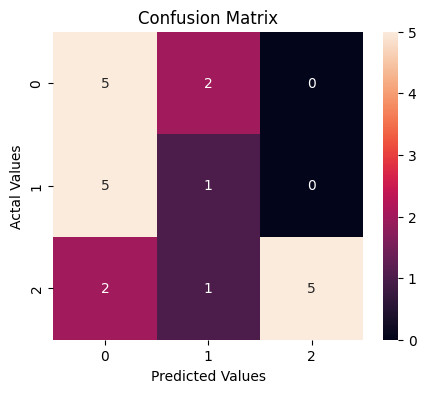

In [212]:
# Creating  a confusion matrix,which compares the y_test and y_pred
cm = confusion_matrix(y_ts_true_values, y_ts_pred_values)
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
save_dir = os.path.join(model_dir, "snap", attempt+"_confusion.png")
plt.savefig(save_dir)
plt.show()

## Load exists model for testing

In [93]:
model.load_state_dict(torch.load(os.path.join(model_dir, "2023-364-44_new.pth"), map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")))

with torch.no_grad():
    model.eval()
    y_ts_true_values = []
    y_ts_pred_values = []
    
    for test_data in test_loader:
        y_ts = torch.tensor([], dtype=torch.long, device=device)
        y_ts_pred = torch.tensor([], dtype=torch.float32, device=device)
        test_images, test_segs, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
            test_data[2].to(device)
        )
        masked_test_images = torch.cat((test_images,test_segs[:,0:1,:,:]), dim=1)
        ts_pred = model(masked_test_images)
        ts_pred_argmax = ts_pred.argmax(dim=1)
        
        for i in range(len(ts_pred_argmax)):
            y_ts_true_values.append(test_labels[i].item())
            y_ts_pred_values.append(ts_pred_argmax[i].item())
            
        y_ts = torch.cat([y_ts, test_labels], dim=0)
        y_ts_pred = torch.cat([y_ts_pred, ts_pred], dim=0)
        print(f"y:{y_ts}")
        print(f"y_pred:{y_ts_pred}")
    y_ts_onehot = [y_trans(i) for i in decollate_batch(y_ts, detach=False)]
    y_ts_pred_act = [y_pred_trans(i) for i in decollate_batch(y_ts_pred)]
    print(f"y_onehot:{y_ts_onehot}")
    print(f"y_pred_act:{y_ts_pred_act}")
    auc_metric(y_ts_pred_act, y_ts_onehot)
    ts_auc_value = auc_metric.aggregate()
    print(f"Test AUC: {ts_auc_value}")

y:tensor([2, 1, 2, 0, 2, 0, 0, 0, 1, 0, 2, 2, 1, 2, 1, 0, 1, 2, 1, 2, 0])
y_pred:tensor([[ 0.0931, -1.0155,  0.8150],
        [-0.3399, -5.9992,  5.6927],
        [-0.0450, -1.8469,  1.6654],
        [ 0.1797, -0.1260,  0.1317],
        [-0.3318, -4.8496,  4.5668],
        [ 0.1740, -0.1302,  0.1557],
        [ 0.0636, -1.1235,  0.9470],
        [-0.3324, -7.6668,  7.0833],
        [ 0.0490, -2.4597,  2.0866],
        [-0.1830, -4.2245,  3.9168],
        [-0.0938, -3.6923,  3.3532],
        [-0.0532, -1.9196,  1.7112],
        [ 0.0214, -2.8540,  2.4220],
        [-0.0638, -2.6261,  2.3898],
        [-0.2525, -4.9956,  4.6160],
        [-0.0401, -2.1333,  1.9461],
        [-0.1165, -7.6372,  6.7827],
        [-0.1111, -4.0708,  3.6979],
        [ 0.1065, -1.1386,  0.9018],
        [-0.0130, -1.6916,  1.5209],
        [-0.0724, -2.8739,  2.6040]])
y_onehot:[metatensor([0., 0., 1.]), metatensor([0., 1., 0.]), metatensor([0., 0., 1.]), metatensor([1., 0., 0.]), metatensor([0., 0., 1.]), m

TypeError: stack expects each tensor to be equal size, but got [] at entry 0 and [3] at entry 21. unable to sync buffer contents: [[tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor([0.8630, 0.0833, 0.0536]), tensor([0.6606, 0.1614, 0.1780]), tensor([0.0025, 0.8611, 0.1364]), tensor([0.0455, 0.4808, 0.4737]), tensor([0.1291, 0.0342, 0.8367]), tensor([0.1798, 0.7349, 0.0853]), tensor([0.3764, 0.2438, 0.3798]), tensor([0.0229, 0.8064, 0.1707]), tensor([0.5194, 0.4326, 0.0481]), tensor([7.2821e-01, 1.6306e-06, 2.7179e-01]), tensor([7.8815e-04, 9.7656e-01, 2.2647e-02]), tensor([0.8163, 0.1242, 0.0595]), tensor([0.0478, 0.9240, 0.0282]), tensor([0.0513, 0.0521, 0.8966]), tensor([0.9189, 0.0479, 0.0332]), tensor([4.3175e-05, 9.9634e-01, 3.6135e-03]), tensor([0.1347, 0.0251, 0.8402]), tensor([0.0375, 0.6499, 0.3126]), tensor([0.5336, 0.4392, 0.0271]), tensor([0.2653, 0.4787, 0.2560]), tensor([0.5402, 0.0034, 0.4564]), tensor([0.8630, 0.0833, 0.0536]), tensor([0.6606, 0.1614, 0.1780]), tensor([0.0025, 0.8611, 0.1364]), tensor([0.0455, 0.4808, 0.4737]), tensor([0.1291, 0.0342, 0.8367]), tensor([0.1798, 0.7349, 0.0853]), tensor([0.3764, 0.2438, 0.3798]), tensor([0.0229, 0.8064, 0.1707]), tensor([0.5194, 0.4326, 0.0481]), tensor([7.2821e-01, 1.6306e-06, 2.7179e-01]), tensor([7.8815e-04, 9.7656e-01, 2.2647e-02]), tensor([0.8163, 0.1242, 0.0595]), tensor([0.0478, 0.9240, 0.0282]), tensor([0.0513, 0.0521, 0.8966]), tensor([0.9189, 0.0479, 0.0332]), tensor([4.3175e-05, 9.9634e-01, 3.6135e-03]), tensor([0.1347, 0.0251, 0.8402]), tensor([0.0375, 0.6499, 0.3126]), tensor([0.5336, 0.4392, 0.0271]), tensor([0.2653, 0.4787, 0.2560]), tensor([0.5402, 0.0034, 0.4564]), tensor([0.8630, 0.0833, 0.0536]), tensor([0.6606, 0.1614, 0.1780]), tensor([0.0025, 0.8611, 0.1364]), tensor([0.0455, 0.4808, 0.4737]), tensor([0.1291, 0.0342, 0.8367]), tensor([0.1798, 0.7349, 0.0853]), tensor([0.3764, 0.2438, 0.3798]), tensor([0.0229, 0.8064, 0.1707]), tensor([0.5194, 0.4326, 0.0481]), tensor([7.2821e-01, 1.6306e-06, 2.7179e-01]), tensor([7.8815e-04, 9.7656e-01, 2.2647e-02]), tensor([0.8163, 0.1242, 0.0595]), tensor([0.0478, 0.9240, 0.0282]), tensor([0.0513, 0.0521, 0.8966]), tensor([0.9189, 0.0479, 0.0332]), tensor([4.3175e-05, 9.9634e-01, 3.6135e-03]), tensor([0.1347, 0.0251, 0.8402]), tensor([0.0375, 0.6499, 0.3126]), tensor([0.5336, 0.4392, 0.0271]), tensor([0.2653, 0.4787, 0.2560]), tensor([0.5402, 0.0034, 0.4564]), tensor([0.2951, 0.0974, 0.6075]), tensor([2.3936e-03, 8.3420e-06, 9.9760e-01]), tensor([0.1493, 0.0246, 0.8260]), tensor([0.3718, 0.2739, 0.3544]), tensor([7.4008e-03, 8.0770e-05, 9.9252e-01]), tensor([0.3677, 0.2713, 0.3610]), tensor([0.2685, 0.0819, 0.6496]), tensor([6.0138e-04, 3.9251e-07, 9.9940e-01]), tensor([0.1142, 0.0093, 0.8765]), tensor([1.6301e-02, 2.8641e-04, 9.8341e-01]), tensor([3.0833e-02, 8.4369e-04, 9.6832e-01]), tensor([0.1430, 0.0221, 0.8349]), tensor([0.0827, 0.0047, 0.9126]), tensor([0.0787, 0.0061, 0.9152]), tensor([7.6263e-03, 6.6433e-05, 9.9231e-01]), tensor([0.1189, 0.0147, 0.8665]), tensor([1.0076e-03, 5.4588e-07, 9.9899e-01]), tensor([2.1679e-02, 4.1339e-04, 9.7791e-01]), tensor([0.2855, 0.0822, 0.6323]), tensor([0.1717, 0.0321, 0.7962]), tensor([0.0641, 0.0039, 0.9320]), tensor([0.2951, 0.0974, 0.6075]), tensor([2.3936e-03, 8.3420e-06, 9.9760e-01]), tensor([0.1493, 0.0246, 0.8260]), tensor([0.3718, 0.2739, 0.3544]), tensor([7.4008e-03, 8.0770e-05, 9.9252e-01]), tensor([0.3677, 0.2713, 0.3610]), tensor([0.2685, 0.0819, 0.6496]), tensor([6.0138e-04, 3.9251e-07, 9.9940e-01]), tensor([0.1142, 0.0093, 0.8765]), tensor([1.6301e-02, 2.8641e-04, 9.8341e-01]), tensor([3.0833e-02, 8.4369e-04, 9.6832e-01]), tensor([0.1430, 0.0221, 0.8349]), tensor([0.0827, 0.0047, 0.9126]), tensor([0.0787, 0.0061, 0.9152]), tensor([7.6263e-03, 6.6433e-05, 9.9231e-01]), tensor([0.1189, 0.0147, 0.8665]), tensor([1.0076e-03, 5.4588e-07, 9.9899e-01]), tensor([2.1679e-02, 4.1339e-04, 9.7791e-01]), tensor([0.2855, 0.0822, 0.6323]), tensor([0.1717, 0.0321, 0.7962]), tensor([0.0641, 0.0039, 0.9320])], [tensor([0., 0., 1.]), tensor([0., 1., 0.]), tensor([0., 0., 1.]), tensor([1., 0., 0.]), tensor([0., 0., 1.]), tensor([1., 0., 0.]), tensor([1., 0., 0.]), tensor([1., 0., 0.]), tensor([0., 1., 0.]), tensor([1., 0., 0.]), tensor([0., 0., 1.]), tensor([0., 0., 1.]), tensor([0., 1., 0.]), tensor([0., 0., 1.]), tensor([0., 1., 0.]), tensor([1., 0., 0.]), tensor([0., 1., 0.]), tensor([0., 0., 1.]), tensor([0., 1., 0.]), tensor([0., 0., 1.]), tensor([1., 0., 0.]), tensor([0., 0., 1.]), tensor([0., 1., 0.]), tensor([0., 0., 1.]), tensor([1., 0., 0.]), tensor([0., 0., 1.]), tensor([1., 0., 0.]), tensor([1., 0., 0.]), tensor([1., 0., 0.]), tensor([0., 1., 0.]), tensor([1., 0., 0.]), tensor([0., 0., 1.]), tensor([0., 0., 1.]), tensor([0., 1., 0.]), tensor([0., 0., 1.]), tensor([0., 1., 0.]), tensor([1., 0., 0.]), tensor([0., 1., 0.]), tensor([0., 0., 1.]), tensor([0., 1., 0.]), tensor([0., 0., 1.]), tensor([1., 0., 0.]), tensor([0., 0., 1.]), tensor([0., 1., 0.]), tensor([0., 0., 1.]), tensor([1., 0., 0.]), tensor([0., 0., 1.]), tensor([1., 0., 0.]), tensor([1., 0., 0.]), tensor([1., 0., 0.]), tensor([0., 1., 0.]), tensor([1., 0., 0.]), tensor([0., 0., 1.]), tensor([0., 0., 1.]), tensor([0., 1., 0.]), tensor([0., 0., 1.]), tensor([0., 1., 0.]), tensor([1., 0., 0.]), tensor([0., 1., 0.]), tensor([0., 0., 1.]), tensor([0., 1., 0.]), tensor([0., 0., 1.]), tensor([1., 0., 0.]), tensor([0., 0., 1.]), tensor([0., 1., 0.]), tensor([0., 0., 1.]), tensor([1., 0., 0.]), tensor([0., 0., 1.]), tensor([1., 0., 0.]), tensor([1., 0., 0.]), tensor([1., 0., 0.]), tensor([0., 1., 0.]), tensor([1., 0., 0.]), tensor([0., 0., 1.]), tensor([0., 0., 1.]), tensor([0., 1., 0.]), tensor([0., 0., 1.]), tensor([0., 1., 0.]), tensor([1., 0., 0.]), tensor([0., 1., 0.]), tensor([0., 0., 1.]), tensor([0., 1., 0.]), tensor([0., 0., 1.]), tensor([1., 0., 0.]), tensor([0., 0., 1.]), tensor([0., 1., 0.]), tensor([0., 0., 1.]), tensor([1., 0., 0.]), tensor([0., 0., 1.]), tensor([1., 0., 0.]), tensor([1., 0., 0.]), tensor([1., 0., 0.]), tensor([0., 1., 0.]), tensor([1., 0., 0.]), tensor([0., 0., 1.]), tensor([0., 0., 1.]), tensor([0., 1., 0.]), tensor([0., 0., 1.]), tensor([0., 1., 0.]), tensor([1., 0., 0.]), tensor([0., 1., 0.]), tensor([0., 0., 1.]), tensor([0., 1., 0.]), tensor([0., 0., 1.]), tensor([1., 0., 0.]), tensor([0., 0., 1.]), tensor([0., 1., 0.]), tensor([0., 0., 1.]), tensor([1., 0., 0.]), tensor([0., 0., 1.]), tensor([1., 0., 0.]), tensor([1., 0., 0.]), tensor([1., 0., 0.]), tensor([0., 1., 0.]), tensor([1., 0., 0.]), tensor([0., 0., 1.]), tensor([0., 0., 1.]), tensor([0., 1., 0.]), tensor([0., 0., 1.]), tensor([0., 1., 0.]), tensor([1., 0., 0.]), tensor([0., 1., 0.]), tensor([0., 0., 1.]), tensor([0., 1., 0.]), tensor([0., 0., 1.]), tensor([1., 0., 0.])]].

In [91]:
print(classification_report(y_ts_true_values, y_ts_pred_values, target_names=["HCA","FNH","HCC"], digits=3))

              precision    recall  f1-score   support

         HCA      1.000     0.286     0.444         7
         FNH      0.000     0.000     0.000         6
         HCC      0.421     1.000     0.593         8

    accuracy                          0.476        21
   macro avg      0.474     0.429     0.346        21
weighted avg      0.494     0.476     0.374        21



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


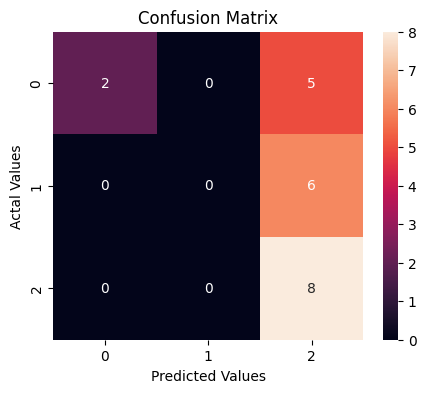

In [92]:
# Creating  a confusion matrix, which compares the y_test and y_pred
cm = confusion_matrix(y_ts_true_values, y_ts_pred_values)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
# save_dir = os.path.join(model_dir, "try_confusion.png")
# plt.savefig(save_dir)
plt.show()